In [289]:
import torch
from torch import nn
from torch.nn.functional import gaussian_nll_loss, mse_loss
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
from torch.nn import LayerNorm
from torch.masked import masked_tensor, as_masked_tensor
# import torch_mask_futures # this import 

In [290]:
import torch

In [291]:
def get_coeff(input: torch.Tensor, target: torch.Tensor, var: torch.Tensor) -> torch.tensor:
    """ Returns dimen
    """
    
    RMSE = torch.sqrt(torch.mean((input.flatten() - target.flatten())**2))
    uncertainty_estimate = (input.flatten() - target.flatten())**2
    LL_best = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), uncertainty_estimate, full=True)
    LL_worst_case_best_RMSE = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), torch.ones_like(uncertainty_estimate)*RMSE, full=True)
    LL_actual = torch.nn.functional.gaussian_nll_loss(input.flatten(), target.flatten(), var.flatten(), full=True)
    
    coeff = 1/(LL_worst_case_best_RMSE - LL_best) * (LL_worst_case_best_RMSE-LL_actual) * 100

    return coeff


In [292]:
def nanvar(X: torch.Tensor,dim: int=None, biased: bool=False, keepdim: bool=False) -> torch.Tensor:
    """Computes the nanvar along a given axis of a torch tensor
    """

    shape_input = list(tuple(X.shape))

    if dim == None:
        X = X.flatten()

    N_nan = torch.nansum(X.isnan(),dim=dim,keepdim=False)
    N_not_nan = torch.nansum(~X.isnan(),dim=dim,keepdim=False) #if 
    mean_axis = torch.nanmean(X,dim=dim,keepdim=True)

    X_mean_removed = X - mean_axis #  nan - number = nan
    #print(X_mean_removed)

    sum_mean_removed_square = torch.nansum(torch.where(X_mean_removed.isnan(),torch.zeros_like(X),X_mean_removed**2),dim=dim)
    #print(sum_mean_removed_square)

    if biased:
        sum_mean_removed_square /= N_not_nan
    else:
        sum_mean_removed_square /= (N_not_nan - 1)
    
    #TODO: Fully replicate numpy behaviour and 
    
    if dim is None:
        if N_nan == len(X):
            sum_mean_removed_square = torch.tensor([torch.nan])
    else:
        sum_mean_removed_square = torch.where(N_nan == int(X.shape[dim]),torch.nan,sum_mean_removed_square)
    #get DOF
    

    if keepdim is True:
        if dim is not None:
            shape_input[dim] = 1
        else: #output must be scalar
            shape_input = [1 for shape in shape_input]
        
        return sum_mean_removed_square.reshape(*shape_input)
    else:
        return sum_mean_removed_square



In [293]:
def masked_mean(X:torch.Tensor, mask: torch.Tensor, dim:int=1) -> torch.Tensor:
    """ calculates masked mean along some dimension
    only considering the entries where the mask is True

    mask: bool Tensor 
    X: torch Tensor
    """
    N = torch.sum(mask, dim=dim, keepdim=True)
    Xmasked = torch.where(mask,X, 0.)
    Xmean_dim = torch.sum(Xmasked,dim=dim,keepdim=True)
    Xmean_dim /= N
    return Xmean_dim

In [469]:
def masked_mean(X:torch.Tensor, mask: torch.Tensor, dim:int) -> torch.Tensor:
    """ calculates masked mean along some dimension
    only considering the entries where the mask is True

    mask: bool Tensor 
    X: torch Tensor
    """
    N = torch.sum(mask, dim=dim, keepdim=True)
    Xmasked = torch.where(mask,X, 0.)
    Xmean_dim = torch.sum(Xmasked,dim=dim,keepdim=True)
    Xmean_dim /= N
    return Xmean_dim

def masked_var_custom(X: torch.Tensor, mask: torch.Tensor, dim: int) -> torch.Tensor:
    """Calculates the variance given a mask
    """
    
    N = torch.sum(mask, dim=dim, keepdim=True)

    Xmasked = torch.where(mask,X, 0.)
    Xmean_dim = torch.sum(Xmasked,dim=dim,keepdim=True)
    Xmean_dim /= N

    Xmasked = Xmasked - Xmean_dim

    Xmasked = torch.where(mask, Xmasked**2, 0)

    var = torch.sum(Xmasked,dim=dim)/(N.flatten()-1)

    return var


def nanvar(X: torch.Tensor,dim: int=None, biased: bool=False, keepdim: bool=False) -> torch.Tensor:
    """Computes the nanvar along a given axis of a torch tensor
    """

    shape_input = list(tuple(X.shape))

    if dim == None:
        X = X.flatten()

    N_nan = torch.nansum(X.isnan(),dim=dim,keepdim=False)
    N_not_nan = torch.nansum(~X.isnan(),dim=dim,keepdim=False) #if 
    mean_axis = torch.nanmean(X,dim=dim,keepdim=True)

    X_mean_removed = X - mean_axis #  nan - number = nan
    #print(X_mean_removed)

    sum_mean_removed_square = torch.nansum(torch.where(X_mean_removed.isnan(),torch.zeros_like(X),X_mean_removed**2),dim=dim)
    #print(sum_mean_removed_square)

    if biased:
        sum_mean_removed_square /= N_not_nan
    else:
        sum_mean_removed_square /= (N_not_nan - 1)
    
    #TODO: Fully replicate numpy behaviour and 
    
    if dim is None:
        if N_nan == len(X):
            sum_mean_removed_square = torch.tensor([torch.nan])
    else:
        sum_mean_removed_square = torch.where(N_nan == int(X.shape[dim]),torch.nan,sum_mean_removed_square)
    #get DOF
    

    if keepdim is True:
        if dim is not None:
            shape_input[dim] = 1
        else: #output must be scalar
            shape_input = [1 for shape in shape_input]
        
        return sum_mean_removed_square.reshape(*shape_input)
    else:
        return sum_mean_removed_square

class RescalingFunctional(torch.nn.Module):
    """Rescaling function
    """
    def __init__(self):
        super().__init__()

        self.alpha = torch.nn.Parameter(torch.tensor([1.]))
        self.gamma = torch.nn.Parameter(torch.tensor([0.]))

        #self.alpha._requires_grad = True
        #self.gamma._requires_grad = True
    
    def forward(self, var):
        return self.alpha ** 2 * var #** (1 + self.gamma)

class EnsemblePrediction(torch.nn.Module):
    """ Returns n_ensemble predictions from a 
    """
    def __init__(self, n_in: int, n_ensembles: int) -> None:
        super().__init__()
        self.n_in = n_in
        self.n_ensembles = n_ensembles
        self.linear = torch.nn.Linear(self.n_in, self.n_ensembles)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)
    

class LinearMeanVar(torch.nn.Module):
    """Predicts Mean and Variance
    """
    def __init__(self, n_in: int ) -> None:
        super().__init__()
        self.n_in = n_in
        self.linear = torch.nn.Linear(self.n_in, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.linear(x)
        mean = out[:,0]
        var = out[:,1] ** 2
        return mean, var



def get_subsample_mask(n_samples: int, n_ensemble: int, p_subsample:float) -> torch.Tensor:
    """returns a mask of shape (n_samples, n_ens) where a sample is chosen 
    with a probability of p_subsample
    """

    mask = torch.rand((n_samples,n_ensemble)) > (1-p_subsample)
    
    return mask


class EnsembleLossGroups(torch.nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self,means_in: torch.Tensor,means_out: torch.Tensor,
                vars_in: torch.Tensor, vars_out: torch.Tensor,
                idx_in: torch.Tensor, idx_out: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:

        targets_in = targets[idx_in].flatten()
        targets_out = targets[idx_out].flatten()

        return torch_mask_futures.loss.gaussian_nll_loss_no_check(means_in,targets_in,vars_in) \
            + torch_mask_futures.loss.gaussian_nll_loss_no_check(means_out,targets_out,vars_out)


def ensemble_loss_groups(means_in: torch.Tensor,means_out: torch.Tensor,
                vars_in: torch.Tensor, vars_out: torch.Tensor,
                idx_in: torch.Tensor, idx_out: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        targets_in = targets[idx_in].flatten()
        targets_out = targets[idx_out].flatten()

        return torch_mask_futures.loss.gaussian_nll_loss_no_check(means_in,targets_in,vars_in) \
            + torch_mask_futures.loss.gaussian_nll_loss_no_check(means_out,targets_out,vars_out)       


class EnsembleAggregator(torch.nn.Module):
    
    def __init__(self) -> None:
        super().__init__()

        #self.rescaling = RescalingFunctional()
    
    def forward(self, predictions: torch.tensor, mask: torch.tensor) -> torch.tensor:
        
        if self.training:
        # in case (smaller ensembles)
            idx_in = torch.sum(mask,dim=1) > 0

            # to have sufficient missing samples, we only consider the points that miss from at least 5 ensembles
            idx_out = torch.sum(~mask,dim=1) > 4

            # select from the targets
            #targets_in = targets[in_samples].flatten()
            #targets_out = targets[missing_5].flatten()

            # generate torch masked arrays
            predictions_masked_in = torch.masked.masked_tensor(predictions,mask)
            predictions_masked_out = torch.masked.masked_tensor(predictions,~mask)

            # calculate means and variances from in-sample predictions
            means_in = torch.mean(predictions_masked_in,dim=1)
            vars_in = torch.var(predictions_masked_in,dim=1)

            # calculate means and variances from out-sample predictions
            means_out = torch.mean(predictions_masked_out[idx_out,:],dim=1)
            #means_out._requires_grad = False
            
            vars_out = torch.var(predictions_masked_out[idx_out,:],dim=1)
            #vars_out._requires_grad = False

            return means_in, means_out, vars_in, vars_out, idx_in, idx_out



        else:
            
            #make predictions ignoring masks TODO: decide wether mask is an optional kwargs or full mask
            means = torch.mean(predictions, dim=1)
            vars = torch.var(predictions, dim=1)

            #apply rescaling to predicted variances
            #vars = self.rescaling(vars)

            return means, vars
        
class EnsembleAggregatorSimple(torch.nn.Module):
    
    def __init__(self) -> None:
        super().__init__()

        self.rescaling = RescalingFunctional()

    def forward(self, predictions: torch.tensor, mask: torch.tensor) -> torch.tensor:
        #make predictions ignoring masks TODO: decide wether mask is an optional kwargs or full mask
        means = torch.mean(predictions, dim=1)
        vars = torch.var(predictions, dim=1)

        #apply rescaling to predicted variances
        return means, vars

class EnsembleAggregatorSimple_w_rescale(torch.nn.Module):
    
    def __init__(self) -> None:
        super().__init__()

        self.rescaling = RescalingFunctional()

    def forward(self, predictions: torch.tensor, mask: torch.tensor) -> torch.tensor:
        #make predictions ignoring masks TODO: decide wether mask is an optional kwargs or full mask
        means = torch.mean(predictions, dim=1)
        vars = torch.var(predictions, dim=1)

        #apply rescaling to predicted variances
        vars = self.rescaling(vars)

        return means, vars

class EnsembleAggregatorMaskMean(torch.nn.Module):
    
    def __init__(self) -> None:
        super().__init__()

        self.rescaling = RescalingFunctional()
    
    def forward(self, predictions: torch.tensor, mask: torch.tensor) -> torch.tensor:
        
        if self.training:
        # in case (smaller ensembles)
            idx_in = torch.sum(mask,dim=1) > 3 #at least three samples because mean/(N-1)
                                               #for now I do not see a better workaround

            # to have sufficient missing samples, we only consider the points that miss from at least 5 ensembles
            idx_out = torch.sum(~mask,dim=1) > 4

            mask_in = mask[idx_in]
            mask_out = mask[idx_out]

            #this masks 
            predictions_in = predictions[idx_in]
            predictions_out = predictions[idx_out]

            predictions_in.requires_grad_ = True
            predictions_out.requires_grad_ = False

            means_in = masked_mean(predictions_in,mask_in,dim=1)
            vars_in = masked_var_custom(predictions_in,mask_in,dim=1)
 
            means_out = masked_mean(predictions_out,mask_out,dim=1)
            vars_out = masked_var_custom(predictions_out,mask_out,dim=1)

            vars_in_rescaled = vars_in #self.rescaling(vars_in)
            vars_out_rescaled = self.rescaling(vars_out)

            return means_in, means_out, vars_in_rescaled, vars_out_rescaled, idx_in, idx_out

        else:
            
            #make predictions ignoring masks TODO: decide wether mask is an optional kwargs or full mask
            means = torch.mean(predictions, dim=1)
            vars = torch.var(predictions, dim=1)

            #apply rescaling to predicted variances
            vars = self.rescaling(vars)

            return means, vars  

class EnsembleAggregatorCustomMask(torch.nn.Module):
    
    def __init__(self) -> None:
        super().__init__()

        self.rescaling = RescalingFunctional()
    
    def forward(self, predictions: torch.tensor, mask: torch.tensor) -> torch.tensor:
        
        if self.training:
        # in case (smaller ensembles)
            idx_in = torch.sum(mask,dim=1) > 3 #at least three samples because mean/(N-1)
                                               #for now I do not see a better workaround

            # to have sufficient missing samples, we only consider the points that miss from at least 5 ensembles
            idx_out = torch.sum(~mask,dim=1) > 4

            # split results into samples that are in the in-sample and internal calibration set
            mask_in = mask[idx_in]
            mask_out = mask[idx_out]

            # this masks 
            predictions_in = predictions[idx_in]
            predictions_out = predictions[idx_out]

            #predictions_in.requires_grad_ = True

            #both should not be optimized
            predictions_out.requires_grad_ = False 
            

            means_in = masked_mean(predictions_in,mask_in,dim=1)
            vars_in = masked_var_custom(predictions_in,mask_in,dim=1)
 
            means_out = masked_mean(predictions_out,mask_out,dim=1)
            vars_out = masked_var_custom(predictions_out,mask_out,dim=1)

            # I do not want to optimize the vars
            vars_out.requires_grad_ = False

            # The vars of the in-set should NOT be rescaled
            vars_in_rescaled = vars_in #self.rescaling(vars_in)
            
            #vars_in_rescaled = self.rescaling(vars_in)
            #vars_in_rescaled.requires_grad_ = False
            #vars_out_rescaled = vars_out

            #vars_out.requires_grad_ = False
            #means_out.requires_grad_ = False
            
            vars_out_rescaled = self.rescaling(vars_out)
            self.rescaling.requires_grad_ = True
            #vars_out_rescaled.requires_grad_ = True

            #print(vars_in)
            #print(vars_out_rescaled)

            return means_in, means_out, vars_in_rescaled, vars_out_rescaled, idx_in, idx_out



        else:
            
            #make predictions ignoring masks TODO: decide wether mask is an optional kwargs or full mask
            means = torch.mean(predictions, dim=1)
            vars = torch.var(predictions, dim=1)

            #apply rescaling to predicted variances
            vars = self.rescaling(vars)

            return means, vars




In [470]:
class SimpleNN_single(torch.nn.Module):
    def __init__(self, n_in, n_out, n_hidden) -> None:
        super().__init__()

        self.nn = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden,n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden,n_out)
                )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)

class SimpleNN_uncertainty(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out) -> None:
        super().__init__()

        self.nn = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden,n_hidden),
                torch.nn.Tanh(),
                #torch.nn.Dropout(p=0.2)
                )
        
        self.mean_out = torch.nn.Linear(n_hidden,n_out)
        self.var_out =  torch.nn.Sequential(
                        torch.nn.Linear(n_hidden,n_out),
                        torch.nn.Softplus()
                        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_hidden = self.nn(x)
        mean = self.mean_out(x_hidden)
        var_out = self.var_out(x_hidden)
        return mean, var_out
    
class SimpleNN_uncertainty_1(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out) -> None:
        super().__init__()

        self.nn = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                #torch.nn.Dropout(p=0.2)
                )
        
        self.mean_out = torch.nn.Linear(n_hidden,n_out)
        self.var_out =  torch.nn.Sequential(
                        torch.nn.Linear(n_hidden,n_out),
                        torch.nn.Softplus()
                        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_hidden = self.nn(x)
        mean = self.mean_out(x_hidden)
        var_out = self.var_out(x_hidden)
        return mean, var_out

class SimpleNN_hidden(torch.nn.Module):
    def __init__(self, n_in, n_hidden) -> None:
        super().__init__()

        self.nn = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden,n_hidden),
                torch.nn.Tanh(),
                #torch.nn.Dropout(p=0.2),
                )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)


class SimpleNN_hidden_1(torch.nn.Module):
    def __init__(self, n_in, n_hidden) -> None:
        super().__init__()

        self.nn = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                #torch.nn.LayerNorm(n_hidden)
                #torch.nn.Dropout(p=0.2),
                )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)
    

class SimpleNN_1stlayer_skip(torch.nn.Module):
    def __init__(self, n_in, n_hidden) -> None:
        super().__init__()

        self.nn_1 = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden,n_hidden),
                torch.nn.Tanh(),
                #torch.nn.Dropout(p=0.2),
                )
        
        self.nn_2 = torch.nn.Sequential(
                torch.nn.Linear(n_hidden,n_hidden),
                torch.nn.Tanh(),
                )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_hidden_1 = self.nn_1(x)
        x_hidden_2 = self.nn_2(x_hidden_1)
        x_out = torch.cat([x_hidden_1,x_hidden_2],dim=1)
        #print(x_out.shape)
        return x_out

"""
class EnsembleNN(torch.nn.Module):
    def __init__(self, n_in, n_out, n_hidden) -> None:
        super().__init__()

        self.nn = SimpleNN(n_in,n_out,)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)
"""

class DeepEnsemble(torch.nn.Module):
    
    def __init__(self, ensembles) -> None:
        super().__init__()
        self.ensembles = ensembles

    def forward(self, x: torch.Tensor):
        
        
        out = torch.cat([ens(x) for ens in self.ensembles],dim=1)
        mean = torch.mean(out,dim=1)
        var = torch.var(out,dim=1)
        
        return mean, var
    



In [471]:
def get_RMSE(input,target):
    return torch.sqrt(torch.mean((input.flatten()-target.flatten())**2))

In [472]:
class LinearEnsembleModel(torch.nn.Module):
    
    def __init__(self, n_in, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_ensemble = n_ensemble
        self.ensemble = EnsemblePrediction(self.n_in,self.n_ensemble)
        self.aggregation = EnsembleAggregatorSimple()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        y_ens = self.ensemble(x)
        return self.aggregation(y_ens, mask)
    
class LinearEnsembleModelCustom(torch.nn.Module):
    
    def __init__(self, n_in, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_ensemble = n_ensemble
        self.ensemble = EnsemblePrediction(self.n_in,self.n_ensemble)
        self.aggregation = EnsembleAggregatorCustomMask()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        y_ens = self.ensemble(x)

        return self.aggregation(y_ens, mask)
    
class NNEnsembleModel_1(torch.nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.n_ensemble = n_ensemble

        self.nn = SimpleNN_hidden_1(n_in=self.n_in,n_hidden=self.n_hidden)
        self.ensemble = EnsemblePrediction(self.n_hidden,self.n_ensemble)
        self.aggregation = EnsembleAggregatorSimple()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        x_hidden = self.nn(x)
        y_ens = self.ensemble(x_hidden)
        return self.aggregation(y_ens, mask)
    
class NNEnsembleModel(torch.nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.n_ensemble = n_ensemble

        self.nn = SimpleNN_hidden(n_in=self.n_in,n_hidden=self.n_hidden)
        self.ensemble = EnsemblePrediction(self.n_hidden,self.n_ensemble)
        self.aggregation = EnsembleAggregatorSimple()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        x_hidden = self.nn(x)
        y_ens = self.ensemble(x_hidden)
        return self.aggregation(y_ens, mask)
    


class NNEnsembleModel_w_rescale(torch.nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.n_ensemble = n_ensemble

        self.nn = SimpleNN_hidden(n_in=self.n_in,n_hidden=self.n_hidden)
        self.ensemble = EnsemblePrediction(self.n_hidden,self.n_ensemble)
        self.aggregation = EnsembleAggregatorSimple_w_rescale()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        x_hidden = self.nn(x)
        y_ens = self.ensemble(x_hidden)
        return self.aggregation(y_ens, mask)

class NNEnsembleModelMeanMask(torch.nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.n_ensemble = n_ensemble

        self.nn = SimpleNN_hidden(n_in=self.n_in,n_hidden=self.n_hidden)
        self.ensemble = EnsemblePrediction(self.n_hidden,self.n_ensemble)
        self.aggregation = EnsembleAggregatorMaskMean()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        x_hidden = self.nn(x)
        y_ens = self.ensemble(x_hidden)
        return self.aggregation(y_ens, mask)

class NNEnsembleModelCustom(torch.nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.n_ensemble = n_ensemble

        self.nn = SimpleNN_hidden(n_in=self.n_in,n_hidden=self.n_hidden)
        self.ensemble = EnsemblePrediction(self.n_hidden,self.n_ensemble)
        self.aggregation = EnsembleAggregatorCustomMask()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        x_hidden = self.nn(x)
        y_ens = self.ensemble(x_hidden)
        return self.aggregation(y_ens, mask)

class NNEnsembleModelSkip(torch.nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.n_ensemble = n_ensemble

        self.nn = SimpleNN_1stlayer_skip(n_in=self.n_in,n_hidden=self.n_hidden)
        self.ensemble = EnsemblePrediction(self.n_hidden*2,self.n_ensemble)
        self.aggregation = EnsembleAggregatorCustomMask()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        x_hidden = self.nn(x)
        y_ens = self.ensemble(x_hidden)
        return self.aggregation(y_ens, mask)
    
class NNDeepEnsembleShallow(torch.nn.Module):
    
    def __init__(self, n_in, n_hidden, n_out, n_ensemble) -> None:
        super().__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.n_ensemble = n_ensemble

        self.nn = SimpleNN_hidden(n_in=self.n_in,n_hidden=self.n_hidden)
        self.ensemble = EnsemblePrediction(self.n_hidden,self.n_ensemble)
        self.dropout = torch.nn.Dropout(p=0.25)
        self.ensemble_var = EnsemblePrediction(self.n_hidden, self.n_ensemble)
        self.aggregation = EnsembleAggregatorSimple()

        self.nuke = torch.nn.Softplus()
    
    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        
        if self.training:
            x_hidden = self.nn(x) # shape (N_samples, N_hidden) 
            
            y_ens = self.ensemble(x_hidden) # shape (N_samples, N_ensembles)
            vars_ens = self.ensemble(x_hidden)
            vars_ens = self.nuke(vars_ens)
            vars_ens = torch.mean(vars_ens,dim=1)

            means, vars = self.aggregation(y_ens, mask)
        
            return means, vars, vars_ens
        
        else:
            x_hidden = self.nn(x) # shape (N_samples, N_hidden) 
            
            y_ens = self.ensemble(x_hidden) # shape (N_samples, N_ensembles)
            vars_ens = self.ensemble(x_hidden)
            vars_ens = self.nuke(vars_ens)
            vars_ens = torch.mean(vars_ens,dim=1)

            means, vars = self.aggregation(y_ens, mask)

            vars = 0.5 * (vars + vars_ens)

            return means, vars






In [180]:
md = torch.nn.Softplus()

torch.randn((10,16))

#md()

tensor([[-0.4225, -1.3295, -1.3745,  0.0198,  1.1377, -1.1760,  0.7312,  0.5184,
         -1.8755,  0.4834, -0.0170,  0.2968, -0.5730,  1.6924,  0.4392,  0.0645],
        [-0.8804,  0.3083, -0.4045, -0.6105,  1.1495, -0.2436, -0.1752,  0.5674,
          0.1746, -0.3839, -1.8260, -0.5027,  1.5694,  2.3887, -0.4065, -0.6999],
        [-0.9378, -1.2860,  0.3429, -0.2789, -0.8593,  1.1298, -0.7914, -2.0470,
          0.2938,  0.5897, -0.3061, -1.3084,  0.1505,  0.1947,  1.2797, -0.5117],
        [-0.5465, -0.3946,  1.7191,  0.0370, -0.6738,  0.4610, -0.2966,  0.7507,
          1.6565,  1.6743,  0.7106,  1.2485,  1.0313, -0.2822, -1.2439,  0.2485],
        [ 2.1761,  0.0758, -0.2077, -0.1922,  0.1795, -1.4589, -1.1231,  1.1427,
         -1.1664,  0.0935,  1.5954,  0.3445, -0.3053,  0.2778,  0.2245, -1.1457],
        [-1.4477, -1.2246,  0.6495,  0.7051, -0.2350, -0.5060, -1.1753,  1.3584,
          1.5168, -1.1041,  1.5475,  0.0362,  0.5927, -0.1214, -0.2285,  0.9396],
        [-0.9837,  1.6

In [181]:
"""  To understand the effect of whatever training strategy we need a measure of ensemble diversity
def measure_ensemble_complexity(weights: torch.Tensor):
    complexity = 0
    for i in range(weights.shape[1]):
        for j in range(weights.shape[1]):
            Ctorch.norm(weights[:,i] - weights[:,j])
"""


'  To understand the effect of whatever training strategy we need a measure of ensemble diversity\ndef measure_ensemble_complexity(weights: torch.Tensor):\n    complexity = 0\n    for i in range(weights.shape[1]):\n        for j in range(weights.shape[1]):\n            Ctorch.norm(weights[:,i] - weights[:,j])\n'

First we establish a playing ground sample points uniformly and noise

In [473]:
n_samples = 100
n_ensembles = 64
n_hidden = 20
n_epochs = 5000
learning_rate = 0.01
x = torch.rand((n_samples,1))

x = x*2 -1
x_ref = torch.rand((1000,1))*2 -1
noise =  torch.normal(0,0.5,x.shape)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

x_test = torch.rand((1000,1))
x_test = x_test*2 -1
y_wo_noise_test = 0.25 * torch.sin(x_test*20) + 3 * x_test
noise_test =  torch.normal(0,0.5,x_test.shape)
y_w_noise_test = y_wo_noise_test + noise_test * x_test

y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()


The first thing we are going to do, is to optimize a simple ensemble model using only MSE loss and see, what the variances of the model do

In [474]:
loss = torch.nn.MSELoss()#eps=1e-04) #
#loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModel(1,n_hidden,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)



optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)





for e in range(5000): #0000):
    model.train()
    mean, var = model(x,mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    l = loss(mean.flatten(), y_w_noise_hetero.flatten()) #, var.flatten())
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

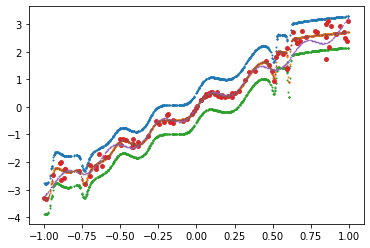

In [475]:
model.eval()
y_pred, y_var = model(x_ref, mask)
y_pred_test, y_var_test = model(x_test, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)
plt.scatter(x_test,y_pred_test.detach().numpy(),s=0.1)

In [476]:
torch.var(model.ensemble.linear.weight)

tensor(0.3266, grad_fn=<VarBackward0>)

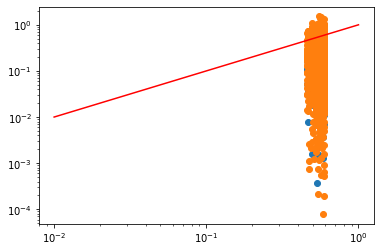

In [477]:
model.eval()
y_pred, y_var = model(x, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")
#plt.xlim(4e-1,6e-1)
#model.eval()




In [478]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))

training_coeff: -13.90
test_coeff: 5.35


In [479]:
print("Test_NLL: {:.2f}".format(torch.nn.functional.gaussian_nll_loss(y_pred_test.flatten(), y_w_noise_test.flatten(),y_var_test.flatten(), full=True)))

Test_NLL: 0.53


In [480]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.10
test RMSE: 0.21


Now, lets actually also consider the variance of the ensemble minimizing gaussian NLL

In [481]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
#loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModel(1,n_hidden,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(n_epochs): #0000):
    model.train()
    mean, var = model(x,mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    l = loss(mean.flatten(), y_w_noise_hetero.flatten(), var.flatten())
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

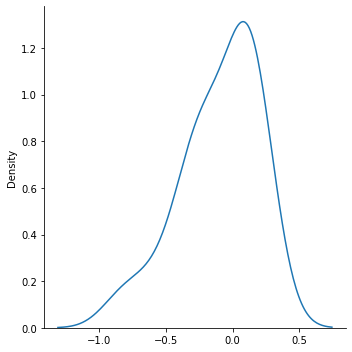

In [482]:
sn.displot(model.ensemble.linear.weight[3,:].detach().numpy(),kind="kde")

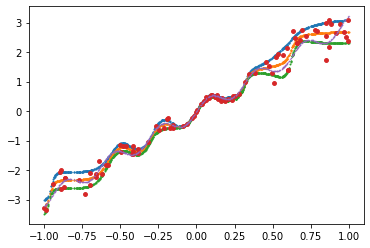

In [483]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)



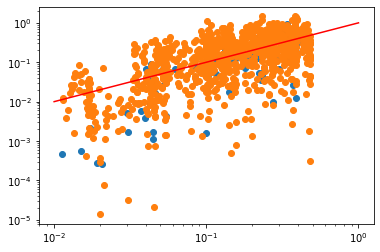

In [484]:


model.eval()
y_pred, y_var = model(x, mask)
y_pred_test, y_var_test = model(x_test, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")


In [485]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))


training_coeff: 59.95
test_coeff: -26.60


In [486]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.12
test RMSE: 0.19


In [487]:
print("Test_NLL: {:.2f}".format(torch.nn.functional.gaussian_nll_loss(y_pred_test.flatten(), y_w_noise_test.flatten(),y_var_test.flatten(), full=True)))

Test_NLL: 0.89


What if we added rescaling to the ensemble model

In [488]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
#loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModel_w_rescale(1,n_hidden,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for e in range(n_epochs): #0000):
    model.train()
    mean, var = model(x,mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    l = loss(mean.flatten(), y_w_noise_hetero.flatten(), var.flatten())
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

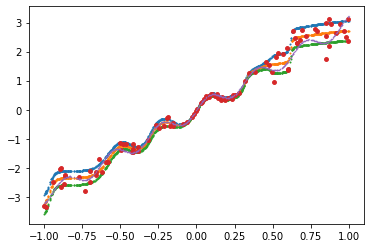

In [489]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)


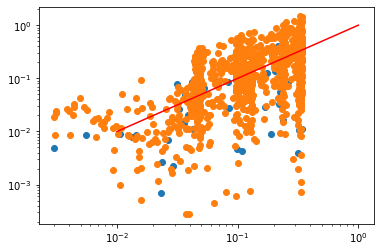

In [490]:
model.eval()
y_pred, y_var = model(x, mask)
y_pred_test, y_var_test = model(x_test, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")

In [491]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))

training_coeff: 63.09
test_coeff: -25.09


In [492]:
print("Test_NLL: {:.2f}".format(torch.nn.functional.gaussian_nll_loss(y_pred_test.flatten(), y_w_noise_test.flatten(),y_var_test.flatten(), full=True)))

Test_NLL: 0.86


In [493]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.12
test RMSE: 0.19


Lets do the optimization with masks during training ($p_{in} = 0.75 $) - No optimization of the rescaling/ using the out-loss

here comes the problem: if we set the subsample probability to 1. then the behaviour is nearly the same to the trivial ensemble masking
already if the mask probability is 0.9 (0.1 - masked) then everything becomes shit


In [494]:
loss = torch.nn.GaussianNLLLoss(eps=1e-08) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-08)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModelMeanMask(1,n_hidden,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for e in range(n_epochs): #0000):
    model.train()
    means_in, means_out, vars_in, vars_out, idx_in, idx_out = model(x, mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_i'n]) + 
    l = loss(means_in.flatten(), y_w_noise_hetero[idx_in].flatten(), vars_in.flatten()) 
    + loss_2(means_out.flatten(), y_w_noise_hetero[idx_out].flatten(), vars_out.flatten()) 
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    #if e % 100 == 0:
    #    print(e)

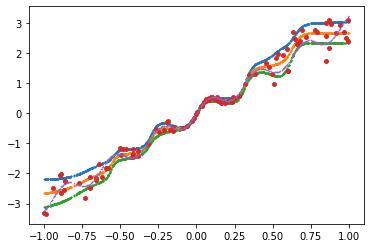

In [495]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)

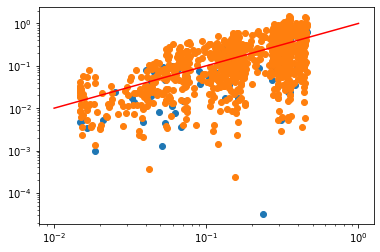

In [496]:
model.eval()
y_pred, y_var = model(x, mask)
y_pred_test, y_var_test = model(x_test, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")

In [497]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))

training_coeff: 56.82
test_coeff: 31.63


In [498]:
print("Test_NLL: {:.2f}".format(torch.nn.functional.gaussian_nll_loss(y_pred_test.flatten(), y_w_noise_test.flatten(),y_var_test.flatten(), full=True)))

Test_NLL: 0.17


In [499]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.14
test RMSE: 0.20


Lets do the optimization with masks during training ($p_{in} = 0.75 $)

In [567]:
loss = torch.nn.GaussianNLLLoss(eps=1e-08) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-08)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModelCustom(1,n_hidden,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for e in range(n_epochs): #0000):
    model.train()
    means_in, means_out, vars_in, vars_out, idx_in, idx_out = model(x, mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_i'n]) + 
    l = loss(means_in.flatten(), y_w_noise_hetero[idx_in].flatten(), vars_in.flatten()) + loss_2(means_out.flatten(), y_w_noise_hetero[idx_out].flatten(), vars_out.flatten()) 
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    #if e % 100 == 0:
    #    print(e)

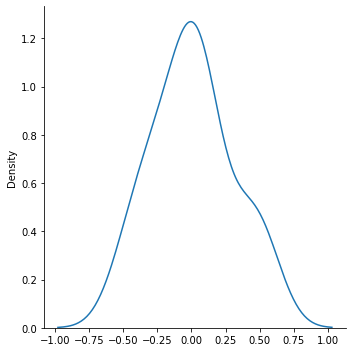

In [568]:
sn.displot(model.ensemble.linear.weight[4,:].detach().numpy(),kind="kde")

In [569]:
import scipy

In [570]:
scipy.stats.differential_entropy(torch.cat([model.ensemble.linear.weight,model.ensemble.linear.bias.reshape(-1,1)],dim=1).detach().numpy())

array([ 0.2833137 , -0.29197677, -0.69801599, -0.14772551, -0.11569154,
       -1.09604221, -0.26538893,  0.0788165 , -0.17758786, -1.7662021 ,
       -1.10184469, -1.03879558, -1.02640529, -0.52298218, -0.87673108,
       -1.22529377,  0.27197269, -1.6165249 , -0.9826037 , -1.09810576,
       -0.1016898 ])

In [571]:
torch.var(model.ensemble.linear.weight)

tensor(0.0963, grad_fn=<VarBackward0>)

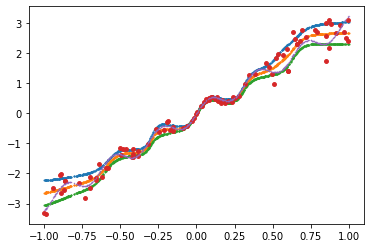

In [578]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)
#plt.scatter(x_test,y_w_noise_test,s=1.)

In [573]:
model.aggregation.rescaling.alpha

Parameter containing:
tensor([0.8006], requires_grad=True)

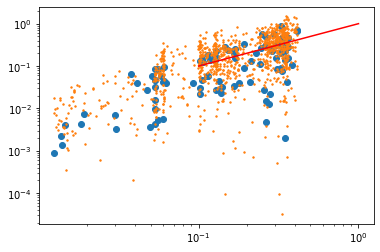

In [574]:
model.eval()
y_pred, y_var = model(x, mask)
y_pred_test, y_var_test = model(x_test, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy(),s=2.)
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-1,0,100),np.logspace(-1,0,100),c="red")

In [575]:
print("Test_NLL: {:.2f}".format(torch.nn.functional.gaussian_nll_loss(y_pred_test.flatten(), y_w_noise_test.flatten(),y_var_test.flatten(), full=True)))

Test_NLL: 0.21


In [576]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))


training_coeff: 57.22
test_coeff: 25.26


In [540]:
# var z /
torch.var(torch.abs(y_pred.flatten()-y_w_noise_hetero.flatten())/torch.sqrt(y_var.flatten()))

tensor(0.4834, grad_fn=<VarBackward0>)

In [541]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.14
test RMSE: 0.19


Can we concatenate multple hidden layer features ?

In [513]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModelSkip(1,20,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(5000): #0000):
    model.train()
    means_in, means_out, vars_in, vars_out, idx_in, idx_out = model(x, mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_i'n]) + 
    l = loss(means_in.flatten(), y_w_noise_hetero[idx_in].flatten(), vars_in.flatten()) + loss_2(means_out.flatten(), y_w_noise_hetero[idx_out].flatten(), vars_out.flatten()) 
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

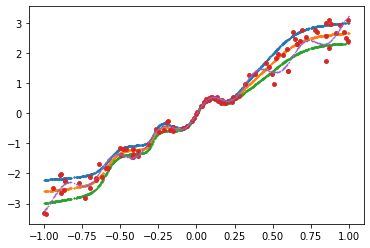

In [514]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)

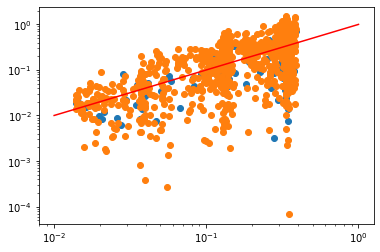

In [515]:
model.eval()
y_pred, y_var = model(x, mask)
y_pred_test, y_var_test = model(x_test, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")

In [516]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))

training_coeff: 58.48
test_coeff: 25.90


In [517]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.15
test RMSE: 0.21


In [518]:
print("Test_NLL: {:.2f}".format(torch.nn.functional.gaussian_nll_loss(y_pred_test.flatten(), y_w_noise_test.flatten(),y_var_test.flatten(), full=True)))

Test_NLL: 0.27


Improving the stability of the optimization procedure:
Sometimes we observe that during the minimization the optimization becomes unstable.
-> Following danish paper, we mix MSE and gNLL loss in the beginning using some decay

In [455]:
def decay(t,thalf):
    halftime = min(max(thalf,1),np.max(t))
    k = np.log(2)/halftime
    return np.exp(-k*t)

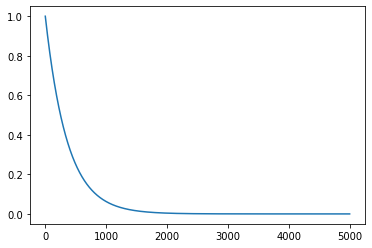

In [456]:
epochs = np.arange(5000)
plt.plot(epochs,decay(epochs,250))

In [457]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
loss_3 = torch.nn.MSELoss()
model = NNEnsembleModelCustom(1,20,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

epochs = np.arange(2000)
w = decay(epochs,200)

for e in epochs: #0000):
    model.train()
    means_in, means_out, vars_in, vars_out, idx_in, idx_out = model(x, mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_i'n]) + 
    l = (1-w[e]) * (loss(means_in.flatten(), y_w_noise_hetero[idx_in].flatten(), vars_in.flatten()) \
         + loss_2(means_out.flatten(), y_w_noise_hetero[idx_out].flatten(), vars_out.flatten())) \
         + (w[e]) * loss_3(means_in.flatten(),y_w_noise_hetero[idx_in].flatten())
    
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

epochs = np.arange(3000)
for e in epochs: #0000):
    model.train()
    means_in, means_out, vars_in, vars_out, idx_in, idx_out = model(x, mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_i'n]) + 
    l = loss(means_in.flatten(), y_w_noise_hetero[idx_in].flatten(), vars_in.flatten()) \
         + loss_2(means_out.flatten(), y_w_noise_hetero[idx_out].flatten(), vars_out.flatten())
         
    
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

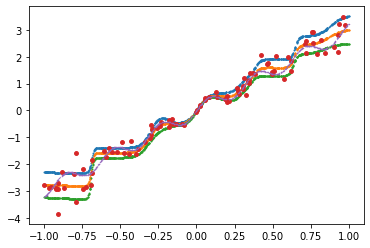

In [458]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)

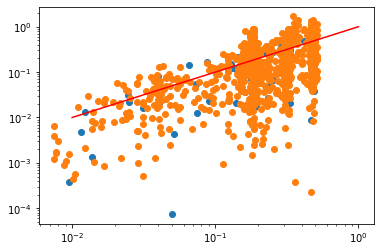

In [459]:
model.eval()
y_pred, y_var = model(x, mask)
y_pred_test, y_var_test = model(x_test, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")

In [460]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))

training_coeff: 48.09
test_coeff: 34.22


In [461]:
LL_Test = 

SyntaxError: invalid syntax (3355694254.py, line 1)

In [462]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.16
test RMSE: 0.20


Finally, we directly predict the uncertainties from the hidden last layer

In [463]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = SimpleNN_uncertainty(1,20,1)



mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, weight_decay=0.02)


y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(5000): #0000):
    model.train()
    means, vars = model(x)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    l = loss(means.flatten(), y_w_noise_hetero.flatten(), vars.flatten()) 
    #+ loss_2(means_out.flatten(), y_w_noise_homo[idx_out].flatten(), vars_out.flatten()) 
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    #if e % 100 == 0:
    #    print(e)

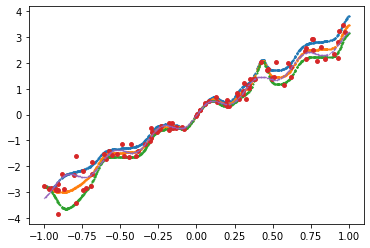

In [464]:
model.eval()
y_pred, y_var = model(x_ref)#, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)

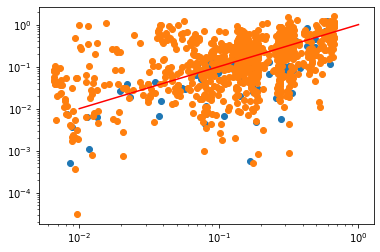

In [465]:
model.eval()
y_pred, y_var = model(x)#, mask)
y_pred_test, y_var_test = model(x_test)#, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")

In [466]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))

training_coeff: 60.03
test_coeff: -1440.56


In [467]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.15
test RMSE: 0.20


Lets assess the role of the Solver. SGD was terrible, Adam works better. What does LBFGS do ?

We are going to test (ensemble no mask gNLL),  (mask ensemble) and (direct variance + NLL)

### ensemble no Mask (wo rescale)

In [97]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
#loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModel(1,20,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe") #torch.optim.Adam(model.parameters(), lr=0.01)



y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(5000): #0000):
    model.train()
    mean, var = model(x,mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    def closure():
        optimizer.zero_grad()
        model.train()

        means, vars = model(x, mask)
        l = loss(means.flatten(), y_w_noise_hetero.flatten(), vars.flatten()) 
        l.backward()
        
        return l
        
    optimizer.step(closure)

KeyboardInterrupt: 

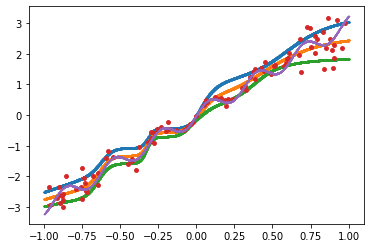

In [177]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)

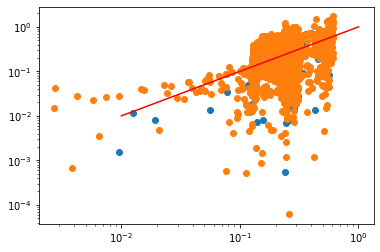

In [178]:
model.eval()
y_pred, y_var = model(x, mask)
y_pred_test, y_var_test = model(x_test, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")

In [179]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.17
test RMSE: 0.20


In [180]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))

training_coeff: 45.50
test_coeff: 13.52


### ensemble no Mask (w rescale)


In [174]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
#loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModel_w_rescale(1,20,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe") #torch.optim.Adam(model.parameters(), lr=0.01)



y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(100): #0000):
    model.train()
    mean, var = model(x,mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    def closure():
        optimizer.zero_grad()
        model.train()

        means, vars = model(x, mask)
        l = loss(means.flatten(), y_w_noise_hetero.flatten(), vars.flatten()) 
        l.backward()
        
        return l
        
    optimizer.step(closure)


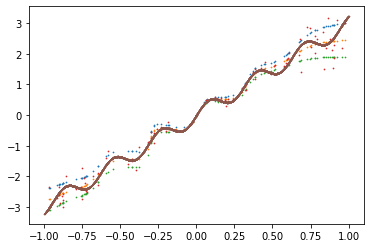

In [175]:
model.eval()
y_pred, y_var = model(x, mask)

plt.scatter(x,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=0.5)

plt.scatter(x,y_pred.detach().numpy(),s=0.5)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=0.5)
plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)

(0.008, 0.6)

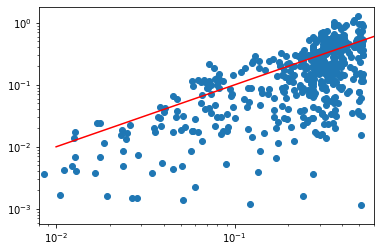

In [1561]:
z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")
plt.xlim(8e-3,6e-1)

In [1562]:
get_coeff(y_pred,y_w_noise_hetero,y_var)

tensor(41.1411, grad_fn=<MulBackward0>)

### Ensemble Mask:

In [2241]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModelCustom(1,20,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe") #torch.optim.Adam(model.parameters(), lr=0.01)



y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(5000): #0000):
    model.train()
    
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_i'n]) + 
    
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)

    def closure():
        optimizer.zero_grad()
        model.train()

        means_in, means_out, vars_in, vars_out, idx_in, idx_out = model(x, mask)

        l = loss(means_in.flatten(), y_w_noise_hetero[idx_in].flatten(), vars_in.flatten()) + loss_2(means_out.flatten(), y_w_noise_hetero[idx_out].flatten(), vars_out.flatten()) 
        l.backward()
        
        return l
        
    optimizer.step(closure)
    
    #if e % 100 == 0:
    #    print(e)

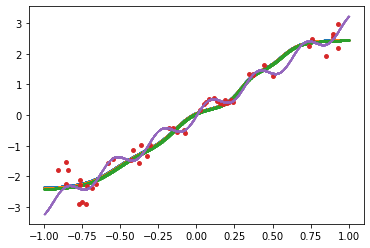

In [2243]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)

(0.008, 0.6)

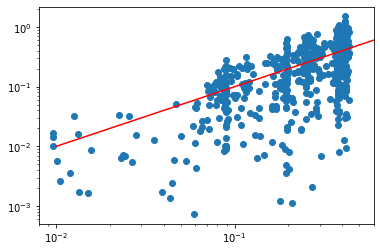

In [1565]:
z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")
plt.xlim(8e-3,6e-1)

In [1566]:
get_coeff(y_pred,y_w_noise_hetero,y_var)

tensor(34.2253, grad_fn=<MulBackward0>)

LBFGS and Simple Uncertainty

In [2247]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = SimpleNN_uncertainty(1,20,1)



mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")


y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(5000): #0000):
    model.train()
    means, vars = model(x)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    #l = loss(means.flatten(), y_w_noise_hetero.flatten(), vars.flatten()) 

    def closure():
        optimizer.zero_grad()
        model.train()

        means, vars = model(x)
        l = loss(means.flatten(), y_w_noise_hetero.flatten(), vars.flatten()) 
        l.backward()
        
        return l
        
    optimizer.step(closure)
    #if e % 100 == 0:
    #    print(e)

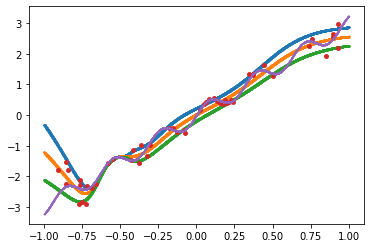

In [2248]:
model.eval()
y_pred, y_var = model(x_ref)#, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)

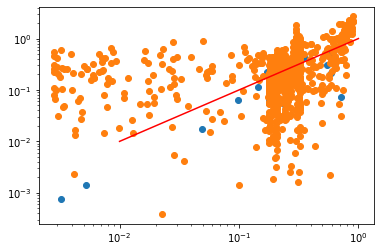

In [2249]:
model.eval()
y_pred, y_var = model(x)#, mask)
y_pred_test, y_var_test = model(x_test)#, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")

In [2250]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.15
test RMSE: 0.28


In [2251]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))

training_coeff: 47.80
test_coeff: -10629.32


Now build a combined uncertainty model just like in the DeepEnsemble paper -> except for shared head

In [63]:
n_hidden

20

In [93]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNDeepEnsembleShallow(1,n_hidden,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(n_epochs): #0000):
    model.train()
    mean, var, var_1 = model(x,mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    l = loss(mean.flatten(), y_w_noise_hetero.flatten(), var.flatten()) + loss(mean.flatten(), y_w_noise_hetero.flatten(), var_1.flatten())
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

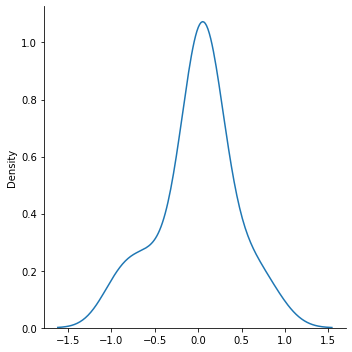

In [94]:
sn.displot(model.ensemble.linear.weight[3,:].detach().numpy(),kind="kde")

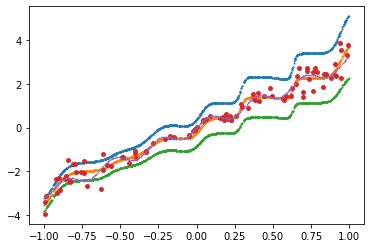

In [95]:
model.eval()
y_pred, y_var = model(x_ref, mask)

plt.scatter(x_ref,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=1.)

plt.scatter(x_ref,y_pred.detach().numpy(),s=1.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=1.)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=15.)
#plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x_ref,y_wo_noise_ref,s=0.1)



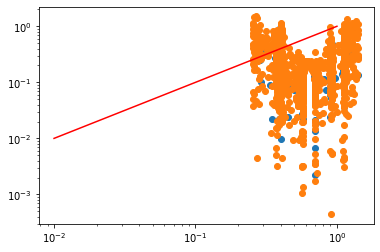

In [96]:


model.eval()
y_pred, y_var = model(x, mask)
y_pred_test, y_var_test = model(x_test, mask)


z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
z_test = torch.abs(y_pred_test.flatten() - y_w_noise_test.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.scatter(torch.sqrt(y_var_test).detach().numpy(),z_test.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")


In [88]:
print("training_coeff: {:.2f}".format(get_coeff(y_pred,y_w_noise_hetero,y_var)))
print("test_coeff: {:.2f}".format(get_coeff(y_pred_test,y_w_noise_test,y_var_test)))


training_coeff: -25.16
test_coeff: -46.36


In [89]:
print("train RMSE: {:.2f}".format(get_RMSE(y_pred,y_w_noise_hetero)/torch.std(y_w_noise_hetero.flatten())))
print("test RMSE: {:.2f}".format(get_RMSE(y_pred_test,y_w_noise_test)/torch.std(y_w_noise_test.flatten())))

train RMSE: 0.19
test RMSE: 0.25


In [90]:
print("Test_NLL: {:.2f}".format(torch.nn.functional.gaussian_nll_loss(y_pred_test.flatten(), y_w_noise_test.flatten(),y_var_test.flatten(), full=True)))

Test_NLL: 1.23


Actually, we should take another look et epistemic and aleatoric uncertainty

In [1700]:
# define a function that a neural network should be capable of learning 100%
#class TargetNN(torch.nn.Module):



n_in,n_hidden,n_out = 1,5,1
func = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden,n_out)
                )

# what if we modeled the noise as another neural network

func_noise = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden,n_out)
                )








In [1836]:
x = torch.rand((20,1)) * 20 - 10
x_dense = torch.rand((1000,1)) * 20 - 10
x_dense, idx = torch.sort(x_dense,dim=0)
x, idx = torch.sort(x,dim=0)

y_dense = func(x_dense).detach()
y_wo_noise = func(x).detach()

In [1837]:
noise = torch.normal(0,0.0025, x.shape)
y_w_noise = y_wo_noise.flatten() + noise.flatten()

In [1780]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
loss_3 = torch.nn.MSELoss()
model = SimpleNN_uncertainty(1,5,1)



mask = get_subsample_mask(n_samples,n_ensembles,0.75)

optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")

for e in range(2000): #0000):
    model.train()
    means, vars = model(x)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    #l = loss(means.flatten(), y_w_noise_hetero.flatten(), vars.flatten()) 

    def closure():
        optimizer.zero_grad()
        model.train()

        means, vars = model(x)
        l = loss_3(means.flatten(), y_wo_noise.flatten())#loss(means.flatten(), y_wo_noise.flatten(), vars.flatten()) 
        l.backward()
        
        return l
        
    optimizer.step(closure)

In [1883]:
from torchcontrib.optim import SWA
import torchcontrib


In [1885]:
?SWA

Init signature: SWA(optimizer, swa_start=None, swa_freq=None, swa_lr=None)
Docstring:     
Base class for all optimizers.

.. warning::
    Parameters need to be specified as collections that have a deterministic
    ordering that is consistent between runs. Examples of objects that don't
    satisfy those properties are sets and iterators over values of dictionaries.

Args:
    params (iterable): an iterable of :class:`torch.Tensor` s or
        :class:`dict` s. Specifies what Tensors should be optimized.
    defaults: (dict): a dict containing default values of optimization
        options (used when a parameter group doesn't specify them).
Init docstring:
Implements Stochastic Weight Averaging (SWA).

Stochastic Weight Averaging was proposed in `Averaging Weights Leads to
Wider Optima and Better Generalization`_ by Pavel Izmailov, Dmitrii
Podoprikhin, Timur Garipov, Dmitry Vetrov and Andrew Gordon Wilson
(UAI 2018).

SWA is implemented as a wrapper class taking optimizer instance as

In [2009]:
loss = torch.nn.GaussianNLLLoss(eps=1e-4) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-4)
loss_3 = torch.nn.MSELoss()
model_noise = NNEnsembleModel_1(1,5,1,32)
#model_noise = NNEnsembleModel_1(1,5,1,64)


mask = get_subsample_mask(15,64,0.75)

opt = torch.optim.Adam(model_noise.parameters(),lr=0.01)#, line_search_fn="strong_wolfe")
optimizer = SWA(opt, swa_start=400, swa_freq=250, swa_lr=0.02)

optimizer.defaults = optimizer.optimizer.defaults
for e in range(5000): #0000):
    #model_noise.train()
    #means, vars = model_noise(x)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    #l = loss(means.flatten(), y_w_noise_hetero.flatten(), vars.flatten()) 


    optimizer.zero_grad()
    model_noise.train()

    means, vars = model_noise(x,mask)#,mask)
    l = loss(means.flatten(), y_w_noise.flatten(), vars.flatten()) 
    l.backward()
        
    
        
    optimizer.step()

optimizer.swap_swa_sgd()

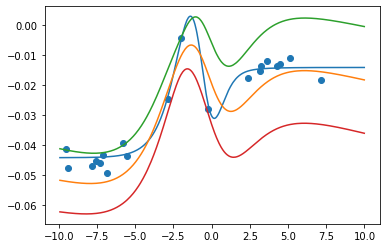

In [2010]:
model.eval()
y_pred, y_var = model(x)#,mask)
model_noise.eval()
y_pred_noise, y_var_noise = model_noise(x_dense,mask)#,mask)#,mask)

#plt.scatter(x.flatten(),y_wo_noise.detach().numpy(),s=2.)
plt.plot(x_dense.flatten(),y_dense.detach().numpy())#,s=2.)
plt.plot(x_dense.flatten(),y_pred_noise.detach().numpy())
plt.plot(x_dense.flatten(),y_pred_noise.detach().numpy()+np.sqrt(y_var_noise.detach().numpy()))
plt.plot(x_dense.flatten(),y_pred_noise.detach().numpy()-np.sqrt(y_var_noise.detach().numpy()))
#plt.scatter(x.flatten(),y_pred.detach().numpy(),s=2.)
plt.scatter(x.flatten(),y_w_noise.detach().numpy())

In [447]:
from scipy.interpolate import griddata

In [ ]:
def x

### 2D Neural network

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

x_2d = torch.rand((50,2)) *2 - 1
values = torch.ones((50,))
x = x_2d[:, 0].detach().numpy()
y = x_2d[:, 1].detach().numpy()
xmin, xmax = -1, 1
ymin, ymax = -1, 1

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = pl.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

pl.show()

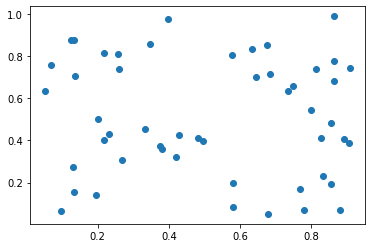

In [1973]:
plt.scatter(x_2d[:,0],x_2d[:,1])

In [1974]:
n_in,n_hidden,n_out = 2,5,1
func_2D = torch.nn.Sequential(
                torch.nn.Linear(n_in,n_hidden),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden,n_out)
                )

In [1978]:
y = func_2D(x_2d).detach().numpy()

In [1994]:
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = np.sqrt(X**2 + Y**2)

In [1996]:
X.shape

(100, 100)

In [1989]:
Z.shape

(100, 100)

In [1990]:
Z

array([[4.24264069, 4.20000437, 4.15781429, ..., 4.15781429, 4.20000437,
        4.24264069],
       [4.20000437, 4.15693077, 4.11429901, ..., 4.11429901, 4.15693077,
        4.20000437],
       [4.15781429, 4.11429901, 4.07122086, ..., 4.07122086, 4.11429901,
        4.15781429],
       ...,
       [4.15781429, 4.11429901, 4.07122086, ..., 4.07122086, 4.11429901,
        4.15781429],
       [4.20000437, 4.15693077, 4.11429901, ..., 4.11429901, 4.15693077,
        4.20000437],
       [4.24264069, 4.20000437, 4.15781429, ..., 4.15781429, 4.20000437,
        4.24264069]])

In [1984]:
xlist.shape

(100,)

In [1985]:
x_out[:,0].shape

(50,)

In [1986]:
y.shape

(50, 1)

In [1992]:
X.shape

(100, 100)

In [1999]:
def plot_heatmap(x,y,z):
    # Extract x, y, and z values from points
    
    # Define the grid for the heatmap
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    zi = np.zeros((len(yi), len(xi)))
    
    # Fill the grid with z values
    for i in range(len(x)):
        xi_idx = np.argmin(abs(xi - x[i]))
        yi_idx = np.argmin(abs(yi - y[i]))
        zi[yi_idx, xi_idx] = z[i]
    
    # Plot the heatmap
    plt.imshow(zi, cmap='hot', extent=[min(x), max(x), min(y), max(y)])
    plt.colorbar()
    plt.show()

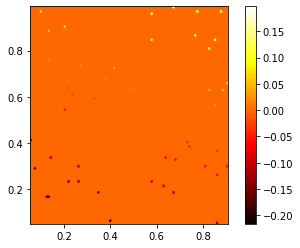

TypeError: Input z must be 2D, not 1D

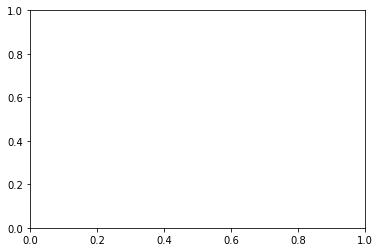

In [1993]:
x_out = x_2d.detach().numpy()
#X, Y = np.meshgrid(, )
fig,ax=plt.subplots(1,1)
cp = ax.contourf(x_out[:,0], x_out[:,1], y.flatten())
fig.colorbar(cp) # Add a colorbar to a plot
plt.show()

Lets do the optimization with masks during training ($p_{in} = 0.75 $)

In [ ]:
loss = torch.nn.GaussianNLLLoss(eps=1e-04) #
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-04)
#loss_3 = torch.nn.MSELoss
model = NNEnsembleModelCustom(1,20,1,n_ensembles)

mask = get_subsample_mask(n_samples,n_ensembles,0.75)
y_wo_noise = 0.25 * torch.sin(x * 20) + 3 * x
y_wo_noise_ref = 0.25 * torch.sin(x_ref*20) + 3 * x_ref

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(5000): #0000):
    model.train()
    means_in, means_out, vars_in, vars_out, idx_in, idx_out = model(x, mask)

    means_out.requires_grad_ = False
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_i'n]) + 
    l = loss(means_in.flatten(), y_w_noise_hetero[idx_in].flatten(), vars_in.flatten()) + loss_2(means_out.flatten(), y_w_noise_hetero[idx_out].flatten(), vars_out.flatten()) 
    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + #,y_var.flatten()) #, y_var)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    #if e % 100 == 0:
    #    print(e)

tensor(0.3198, grad_fn=<SqrtBackward0>)

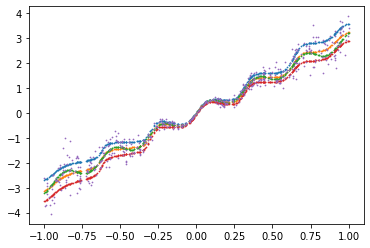

In [ ]:
model.eval()
y_pred, y_var = model(x, mask)

plt.scatter(x,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=0.5)

plt.scatter(x,y_pred.detach().numpy(),s=0.5)
plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
#plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_hetero,s=0.5)
torch.sqrt(torch.nn.functional.mse_loss(y_pred,y_w_noise_hetero))

(0.008, 0.6)

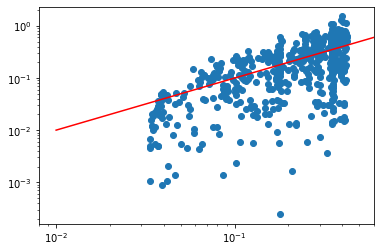

In [ ]:
z = torch.abs(y_pred.flatten() - y_w_noise_hetero.flatten())
plt.scatter(torch.sqrt(y_var).detach().numpy(),z.detach().numpy())
plt.yscale("log")
plt.xscale("log")
plt.plot(np.logspace(-2,0,100),np.logspace(-2,0,100),c="red")
plt.xlim(8e-3,6e-1)

In [ ]:
get_coeff(y_pred,y_w_noise_hetero,y_var)

tensor(32.7230, grad_fn=<MulBackward0>)

In [ ]:
# The noise can only be as compley as the nn function

In [1876]:
! pip install torchcontrib

  Preparing metadata (setup.py) ... done
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7517 sha256=f6311b829169b2f93df42fe38cd9db0956773462716ff00d7c85f1c6c1ea22d8
  Stored in directory: /Users/matthiaskellner/Library/Caches/pip/wheels/4e/e6/4d/ca9241b0fd2036630ed1674493738e27be708978362dac7cf4
Successfully built torchcontrib

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [1877]:
import torchcontrib

In [1857]:
# sample per dimension ? 

In [1733]:
torch.sqrt(torch.mean((y_pred.flatten() - y_wo_noise.flatten())**2))/torch.std(y_wo_noise.flatten()) * 100

tensor(2.4921, grad_fn=<MulBackward0>)

In [1736]:
torch.sqrt(torch.mean((y_wo_noise.flatten() - y_w_noise.flatten())**2)) #/torch.std(y_wo_noise.flatten()) #* 100

tensor(0.0025)

In [1722]:
torch.std(y_wo_noise.flatten())

tensor(0.0142)

In [1698]:
layer = torch.nn.Linear(10,10)
print(layer.weight)
layer.weight = torch.nn.init.uniform_(torch.nn.Linear(10,10).weight)
print(layer.weight)

Parameter containing:
tensor([[-0.2387, -0.0741,  0.0495, -0.0772,  0.1682, -0.0758,  0.2641, -0.0213,
          0.2972,  0.0897],
        [-0.0264,  0.2521, -0.2057,  0.0564, -0.2524, -0.1063, -0.2180,  0.0907,
         -0.2062,  0.0127],
        [ 0.2561,  0.1652, -0.0140, -0.2855,  0.0955,  0.0636,  0.2198, -0.0702,
          0.3135, -0.2647],
        [ 0.0674,  0.0526,  0.2521, -0.2905, -0.2214, -0.1607,  0.1182,  0.2511,
          0.0778, -0.0986],
        [ 0.2184,  0.2982, -0.0401, -0.2796, -0.1927,  0.2171, -0.0176, -0.0486,
          0.3055, -0.2689],
        [ 0.1571, -0.1972, -0.3092,  0.1382, -0.2755, -0.0725,  0.0138,  0.2301,
         -0.2983, -0.2980],
        [ 0.2974,  0.0269, -0.0029,  0.0731,  0.2832, -0.0498,  0.0732, -0.0456,
          0.0128, -0.3067],
        [-0.0008, -0.2327, -0.0856, -0.0722, -0.0232, -0.1194, -0.0870, -0.2204,
          0.1310, -0.2015],
        [-0.0693, -0.2237, -0.1317, -0.2196,  0.1102, -0.1396,  0.1633, -0.0633,
         -0.2626, -0.0143

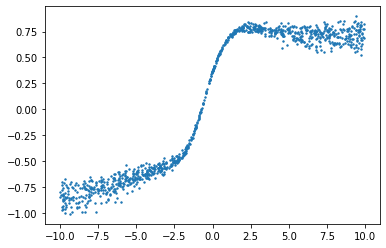

In [1683]:
plt.scatter(x.flatten(),y_w_noise_hetero.detach().flatten(),s=2.)

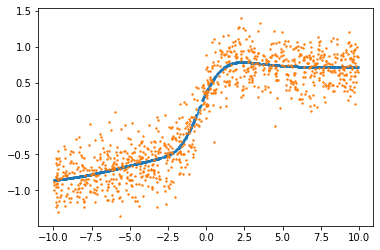

In [1684]:
plt.scatter(x.flatten(),y_w_o_noise.detach().numpy(),s=2.)
plt.scatter(x.flatten(),y_w_noise_homo.detach().numpy(),s=2.)

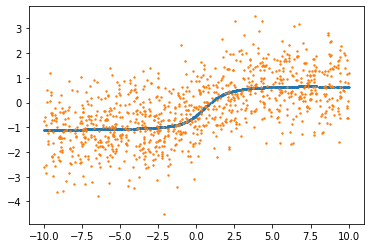

In [1644]:
plt.scatter(x.flatten(),y_w_o_noise.detach().numpy(),s=2.)
plt.scatter(x.flatten(),y_w_noise_homo.detach().numpy(),s=2.)

It appears so, that the actual behaviour of the convergance etc. depend on the number of samples

In [ ]:
def fit_ensemble_wo_rescale():
    pass

def fit_ensemble_w_rescale():
    pass

def fit_ensemble_mask():
    pass

def fit_ensemble_simple():
    pass

def fit_ensemble_wo_rescale_lbfgs():
    pass

def fit_ensemble_w_rescale_lbfgs():
    pass

def fit_ensemble_ensemble_mask_lbfgs():
    pass

def fit_ensemble_simple_lbfgs():
    pass



for n_samples in [25,50,100,200,400,800,1600]:
    for n_average in range(10):
        
        # get RMSE
        # get NLL
        # get dimensionless metric




        
        continue

In [681]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

nn.nn.0.weight tensor([[ 9.8815e-01],
        [-8.0694e-01],
        [-5.7938e-01],
        [-5.7288e-01],
        [ 1.7481e-01],
        [ 1.7176e+00],
        [ 1.1921e+00],
        [-9.6852e-01],
        [ 4.9818e-01],
        [ 1.9031e-01],
        [-4.2581e-01],
        [-4.8242e-01],
        [-1.1031e+00],
        [-4.6320e-01],
        [-1.9764e+00],
        [ 9.0721e-01],
        [ 2.4765e-01],
        [-3.1456e-01],
        [ 3.3909e+00],
        [-7.2038e-01],
        [-1.1211e-01],
        [-2.3002e-02],
        [-4.8781e-01],
        [-1.7471e-04],
        [ 5.4496e-01],
        [ 1.9686e+00],
        [ 1.1766e+00],
        [-2.1344e-01],
        [ 2.1873e-01],
        [-7.1203e-01],
        [-1.2793e+00],
        [ 5.5913e-02],
        [-1.0347e+00],
        [ 4.4277e-01],
        [-1.1393e+00],
        [-9.4050e-01],
        [-9.3019e-01],
        [ 4.2046e-01],
        [ 1.0136e+00],
        [ 5.6867e-01],
        [-1.4767e+00],
        [-9.7627e-01],
        [ 5.4117e-0

In [684]:
torch.sqrt(torch.tensor(0.389))

tensor(0.6237)

In [634]:
y_var

tensor([0.0472, 0.0342, 0.0391, 0.0327, 0.0223, 0.0472, 0.0388, 0.0316, 0.0330,
        0.0437, 0.0378, 0.0421, 0.0331, 0.0384, 0.0349, 0.0345, 0.0435, 0.0410,
        0.0226, 0.0464, 0.0301, 0.0354, 0.0426, 0.0443, 0.0421, 0.0435, 0.0381,
        0.0382, 0.0261, 0.0466, 0.0326, 0.0288, 0.0395, 0.0312, 0.0421, 0.0384,
        0.0370, 0.0330, 0.0427, 0.0462, 0.0394, 0.0342, 0.0334, 0.0361, 0.0315,
        0.0306, 0.0317, 0.0396, 0.0328, 0.0396, 0.0330, 0.0392, 0.0373, 0.0332,
        0.0334, 0.0369, 0.0311, 0.0388, 0.0336, 0.0361, 0.0421, 0.0255, 0.0447,
        0.0535, 0.0520, 0.0295, 0.0381, 0.0330, 0.0500, 0.0373, 0.0474, 0.0407,
        0.0399, 0.0566, 0.0388, 0.0424, 0.0430, 0.0390, 0.0409, 0.0281, 0.0326,
        0.0218, 0.0397, 0.0458, 0.0335, 0.0292, 0.0314, 0.0396, 0.0366, 0.0425,
        0.0323, 0.0300, 0.0344, 0.0457, 0.0408, 0.0419, 0.0393, 0.0250, 0.0390,
        0.0418, 0.0309, 0.0297, 0.0456, 0.0474, 0.0363, 0.0299, 0.0315, 0.0382,
        0.0351, 0.0446, 0.0342, 0.0398, 

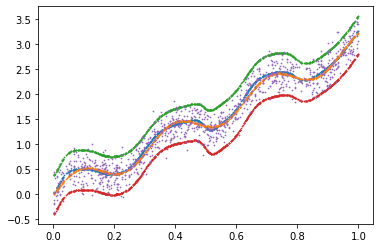

In [616]:
model.eval()
ypred, ymean = model(x, mask)
plt.scatter(x,ypred.detach().numpy(),s=0.5)
plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_homo,s=0.5)

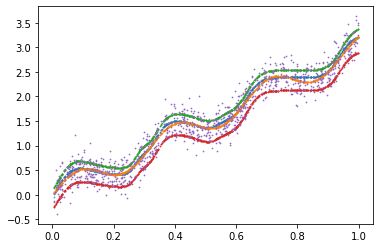

In [614]:
model.eval()
ypred, ymean = model(x, mask)
plt.scatter(x,ypred.detach().numpy(),s=0.5)
plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x,y_pred.detach().numpy()+torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_pred.detach().numpy()-torch.sqrt(y_var).detach().numpy(), s=0.5)
plt.scatter(x,y_w_noise_homo,s=0.5)

In [582]:
loss = torch.nn.MSELoss()
model = SimpleNN_single(1,1,10)

x = torch.rand((1000,1))
y_wo_noise = 0.25 * torch.sin(x*20) + 3 * x

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

noise =  torch.normal(0,0.2,x.shape)

y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(10000): #0000):
    model.train()
    y_pred = model(x)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    l = loss(y_pred,y_wo_noise)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if e % 100 == 0:
        print(e)



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


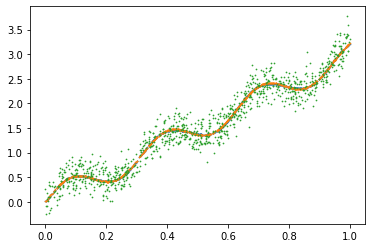

In [583]:
model.eval()
ypred = model(x)
plt.scatter(x,ypred.detach().numpy(),s=0.5)
plt.scatter(x,y_wo_noise,s=0.5)
plt.scatter(x,y_w_noise_homo,s=0.5)

In [547]:
model

SimpleNN_single(
  (nn): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [549]:
ypred

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

In [543]:
ypred

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n

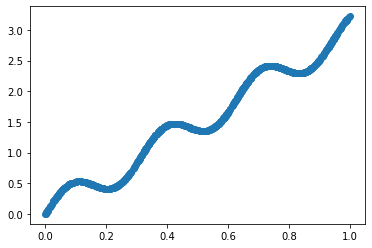

In [529]:
plt.scatter(x,y_wo_noise)

In [643]:
model = LinearEnsembleModelCustom(1,1,16)
loss = torch.nn.GaussianNLLLoss(eps=1e-06)
loss_2 = torch.nn.GaussianNLLLoss(eps=1e-06)
loss_3 = torch.nn.MSELoss()
loss_4 = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

x = torch.rand((1000,1))#,requires_grad=True)
mask = get_subsample_mask(1000,16,0.75)
y_wo_noise = 3 * x + 2
noise =  torch.normal(0,0.2,x.shape)
y_w_noise_homo = (y_wo_noise + noise).flatten()
y_w_noise_hetero = (y_wo_noise + noise * x ).flatten()

for e in range(10000): #0000):
    model.train()
    means_in, means_out, vars_in, vars_out, idx_in, idx_out = model(x, mask)

    #loss_3(means_in.flatten(),y_w_noise_hetero[idx_in]) + 
    l = loss(means_in.flatten(), y_w_noise_hetero[idx_in], vars_in) + loss_2(means_out.flatten(), y_w_noise_hetero[idx_out], vars_out) 
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if e % 100 == 0:
        print(e)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [644]:
model.eval()
mean_y_pred, var_y_pred = model(x, mask)

In [645]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

ensemble.linear.weight tensor([[3.4075],
        [3.1997],
        [2.9826],
        [3.1770],
        [2.8469],
        [2.5346],
        [3.3511],
        [2.6892],
        [2.7949],
        [2.6141],
        [3.3875],
        [3.0413],
        [2.8286],
        [3.0747],
        [3.2345],
        [2.6745]])
ensemble.linear.bias tensor([2.0010, 1.9387, 1.9803, 1.9919, 1.8906, 1.9652, 1.9551, 2.0609, 1.9092,
        2.0729, 1.9281, 2.0380, 1.9968, 2.0283, 2.0500, 2.0678])
aggregation.rescaling.alpha tensor([0.6810])
aggregation.rescaling.gamma tensor([0.])


In [646]:
model.named_parameters

<bound method Module.named_parameters of LinearEnsembleModelCustom(
  (ensemble): EnsemblePrediction(
    (linear): Linear(in_features=1, out_features=16, bias=True)
  )
  (aggregation): EnsembleAggregatorCustomMask(
    (rescaling): RescalingFunctional()
  )
)>

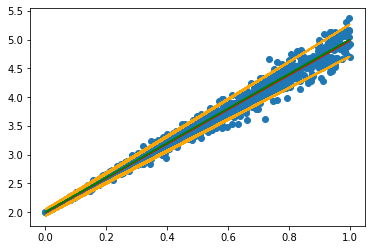

In [647]:
plt.scatter(x,y_w_noise_hetero)
plt.plot(x.detach().numpy(), mean_y_pred.detach().numpy(),c="red")
plt.plot(x.detach().numpy(), mean_y_pred.detach().numpy() + torch.sqrt(var_y_pred).detach().numpy(),c="orange")
plt.plot(x.detach().numpy(), mean_y_pred.detach().numpy() - torch.sqrt(var_y_pred).detach().numpy(),c="orange")
plt.plot(x.detach().numpy(), y_wo_noise, c="green")
#plt.plot(x.detach().numpy(), mean_y_pred.detach().numpy() - torch.sqrt(var_y_pred).detach().numpy())
#plt.xlim(0.6,0.8)


In [648]:
from sklearn.metrics import mean_squared_error

In [649]:
mean_squared_error(y_wo_noise.flatten(),y_w_noise_hetero.flatten(),squared=False)

0.108344324

In [650]:
# what is the best possible RMSE we can get?


RMSE_best = torch.sqrt(torch.mean((y_wo_noise.flatten() - y_w_noise_hetero.flatten())**2))
RMSE_actual = torch.sqrt(torch.mean((mean_y_pred.flatten() - y_w_noise_hetero.flatten())**2))

#what is the oracel LL we can get?
uncertainty_estimate = (mean_y_pred.flatten() - y_w_noise_hetero.flatten())**2
LL_best = torch.nn.functional.gaussian_nll_loss(mean_y_pred.flatten(),y_w_noise_hetero.flatten(),uncertainty_estimate, full=True)
LL_worst_case_best_RMSE = torch.nn.functional.gaussian_nll_loss(mean_y_pred.flatten(),y_w_noise_hetero.flatten(),torch.ones_like(uncertainty_estimate)*RMSE_actual, full=True)

LL_actual = torch.nn.functional.gaussian_nll_loss(mean_y_pred.flatten(),y_w_noise_hetero.flatten(),var_y_pred.flatten(), full=True)




In [651]:
# This metric reaches a 100 % if LL_best = LL_actual -> 
1/(LL_worst_case - LL_best) * (LL_worst_case-LL_actual) * 100

tensor(44.5394, grad_fn=<MulBackward0>)

In [418]:
LL_worst_case

tensor(-0.2638)

In [351]:
LL_best

tensor(-2.5986)

In [345]:
RMSE_best

tensor(0.0862)

In [341]:
RMSE_best

tensor(1.2106)

In [ ]:
# what is the best value of a metric we can get ?



In [279]:
# 

In [408]:
z = torch.abs(mean_y_pred.flatten() - y_wo_noise.flatten())

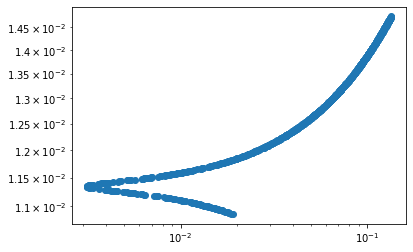

In [409]:
plt.scatter(torch.sqrt(var_y_pred).detach().numpy(),z.detach().numpy())
plt.xscale("log")
plt.yscale("log")

In [287]:
var_y_pred

tensor([0.0086, 0.0051, 0.0067, 0.0134, 0.0058, 0.0063, 0.0056, 0.0098, 0.0093,
        0.0130, 0.0062, 0.0093, 0.0063, 0.0095, 0.0050, 0.0054, 0.0096, 0.0079,
        0.0075, 0.0137, 0.0072, 0.0049, 0.0048, 0.0048, 0.0054, 0.0068, 0.0055,
        0.0124, 0.0078, 0.0095, 0.0085, 0.0092, 0.0050, 0.0079, 0.0057, 0.0064,
        0.0048, 0.0057, 0.0059, 0.0055, 0.0050, 0.0058, 0.0050, 0.0052, 0.0084,
        0.0080, 0.0128, 0.0057, 0.0051, 0.0053, 0.0065, 0.0049, 0.0057, 0.0058,
        0.0079, 0.0059, 0.0127, 0.0052, 0.0049, 0.0068, 0.0057, 0.0056, 0.0049,
        0.0051, 0.0131, 0.0058, 0.0050, 0.0111, 0.0129, 0.0049, 0.0048, 0.0084,
        0.0081, 0.0079, 0.0057, 0.0066, 0.0095, 0.0057, 0.0074, 0.0089, 0.0097,
        0.0083, 0.0097, 0.0083, 0.0100, 0.0053, 0.0048, 0.0068, 0.0049, 0.0054,
        0.0137, 0.0103, 0.0058, 0.0090, 0.0061, 0.0054, 0.0052, 0.0070, 0.0133,
        0.0051, 0.0138, 0.0051, 0.0051, 0.0060, 0.0085, 0.0049, 0.0051, 0.0051,
        0.0059, 0.0052, 0.0056, 0.0083, 

In [148]:
mean_y_pred

tensor([3.5896, 4.3756, 3.3476, 3.4414, 3.0166, 4.8167, 4.0211, 4.6281, 4.8606,
        3.2356, 4.7521, 4.6275, 2.6311, 3.8774, 3.3573, 3.5363, 3.1283, 4.7630,
        4.5014, 4.7797, 3.2711, 3.2235, 4.6450, 3.1508, 2.5829, 3.7257, 3.6940,
        4.6397, 2.1936, 4.6147, 4.1024, 2.7845, 4.5400, 3.1724, 4.6025, 4.0687,
        3.7593, 4.8848, 3.4723, 4.1575, 3.3918, 1.9741, 3.6930, 2.7396, 2.4770,
        3.5453, 4.1472, 4.0934, 3.3596, 3.7527, 4.8721, 2.5390, 4.4876, 2.2738,
        3.9824, 4.2817, 4.8875, 3.0163, 4.2226, 2.5624, 3.9362, 4.4596, 3.0277,
        3.3326, 4.5152, 2.3202, 4.8147, 2.1759, 2.5849, 3.8456, 3.4159, 3.8743,
        4.6387, 1.9800, 2.9346, 4.0158, 4.4959, 3.0528, 4.0573, 2.5502, 4.7608,
        4.6701, 3.8017, 2.6905, 3.9982, 2.3528, 4.8057, 2.1000, 2.4461, 2.2034,
        3.9598, 2.2628, 3.2469, 1.9888, 2.5057, 4.1323, 2.7489, 3.5753, 3.8546,
        3.3051, 4.3533, 4.2691, 4.0898, 4.8530, 4.0184, 4.8554, 4.6040, 3.1865,
        4.8678, 2.7365, 3.5633, 4.4060, 

In [72]:
mean_y_pred

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [18]:
mean_y_pred.shape

torch.Size([1000])

In [19]:
var_y_pred.shape

torch.Size([1000])

In [73]:
X = torch.randn((100,16))
mask = get_subsample_mask(100,16,0.75)
print(masked_mean(X,mask,dim=1)[:5])

print(masked_var_custom(X,mask,dim=1)[:5])

X_np = X.detach().numpy()
mask_np = mask.detach().numpy()
X_ma = ma.masked_array(X_np, mask=~mask_np)
print(X_ma.mean(axis=1)[:5])
vars = X_ma.var(axis=1,ddof=1)
print(vars[:5])


tensor([[ 0.5179],
        [ 0.0357],
        [-0.0893],
        [-0.0815],
        [-0.5965]])
tensor([0.3908, 0.8352, 1.5903, 0.6942, 0.9207])


NameError: name 'ma' is not defined

In [688]:
vars[:5]

masked_array(data=[1.28386696, 0.70817378, 0.94313633, 1.24484545,
                   1.26793543],
             mask=False,
       fill_value=1e+20)

In [676]:
mask

tensor([[ True,  True, False,  ...,  True,  True, False],
        [ True,  True,  True,  ..., False,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        ...,
        [ True, False,  True,  ...,  True, False,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [False,  True, False,  ...,  True, False,  True]])

In [680]:
X_ma.mean(axis=1)[:5]

masked_array(data=[0.05173623561859131, -0.013114314812880296,
                   0.6437225341796875, 0.06897682547569275,
                   0.21646535396575928],
             mask=[False, False, False, False, False],
       fill_value=1e+20)

In [681]:
masked_mean(X,mask,dim=1)[:5]

tensor([ 0.0517, -0.0131,  0.6437,  0.0690,  0.2165])

In [659]:
import numpy as np
import numpy.ma as ma

In [ ]:
plt.plot(x.detach().numpy(), mean_y_pred.detach().numpy())

In [753]:
model = LinearEnsembleModelCustom(1,1,16)
loss = EnsembleLossGroups()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

x = torch.rand((1000,1))#,requires_grad=True)
mask = get_subsample_mask(1000,16,0.75)
y_wo_noise = 3 * x + 2
noise =  torch.normal(0,0.2,x.shape)
y_w_noise_homo = y_wo_noise + noise
y_w_noise_hetero = y_wo_noise + noise * x

for e in range(1000):
    model.train()
    pred = model(x, mask)
    l = loss(*pred,y_w_noise_hetero)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if e % 100 == 0:
        print(e)

0
100
200
300
400
500
600
700
800
900


In [718]:
torch.sum(torch.sum(~mask,dim=1)>4)

tensor(5)

In [464]:
model.get_parameter

<bound method Module.get_parameter of LinearEnsembleModelCustom(
  (ensemble): EnsemblePrediction(
    (linear): Linear(in_features=1, out_features=16, bias=True)
  )
  (aggregation): EnsembleAggregatorCustomMask(
    (rescaling): RescalingFunctional()
  )
)>

In [ ]:
torch.masked.m

In [91]:
Xtens = torch.arange(10,dtype=float,requires_grad=True).reshape(2,5)
Y = torch.randn(2)
mask = get_subsample_mask(2,5,0.75)
Xtens.retain_grad()

idx=torch.tensor([True,False])
means = masked_mean(Xtens, mask, dim=1)[idx]
vars = masked_var_custom(Xtens, mask,dim=1)[idx]
vars_mean = torch.nn.functional.gaussian_nll_loss(means,Y[idx].flatten(),vars)
vars_mean.backward()

In [92]:
Xtens.grad

tensor([[ 1.1270,  0.6700,  0.2130,  0.0000, -0.7009],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)

In [90]:
Xtens.grad

tensor([[-0.1244,  0.0443,  0.0000,  0.3819,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]], dtype=torch.float64)

In [542]:
X_masked.grad

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]], dtype=torch.float64)

In [478]:
x.shape

torch.Size([1000, 1])

In [479]:
mean_y_pred

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

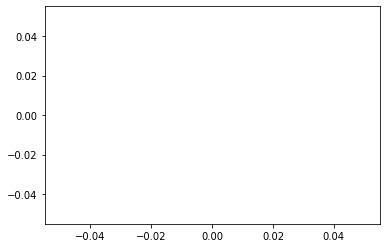

In [480]:
plt.plot(x,mean_y_pred.detach().numpy())

In [135]:
201 % 100

1

In [149]:
a = torch.Tensor([1.,1.,torch.nan])
a.nanmean()

tensor(1.)

In [ ]:
python c

In [434]:
np.nanvar(torch.tensor(1.),ddof=1)

/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_76586/829357826.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  np.nanvar(torch.tensor(1.),ddof=1)


nan

In [447]:
nanvar(torch.tensor(1.),dim=None,biased=True)

tensor(0.)

In [399]:
X = torch.eye(3)
X = X.flatten()
X

tensor([1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [376]:
np.__version__

'1.21.5'

In [ ]:
torch.sum()

In [382]:
np.nanvar(X_2,keepdims=True,axis=None).shape

(1, 1)

In [394]:
torch.tensor(1.).shape

torch.Size([])

In [392]:
X_2

tensor([[1., 1., 1., 0., 1., nan],
        [1., 1., 1., 0., 1., nan]])

In [397]:
nanvar(X_2, dim=None, biased=False, keepdim=True).shape

torch.Size([1, 1])

In [370]:
X_2

tensor([[1., 1., 1., 0., 1., nan],
        [1., 1., 1., 0., 1., nan]])

In [371]:
torch.nan ** 2

nan

In [356]:
np.nanvar(X_2)

0.16000001

In [341]:
torch.eye(10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [343]:
torch.full_like(torch.eye(10),torch.nan)#,dtype=torch.float)

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [293]:
i = 1
i /= 2

In [269]:
import numpy as np

In [420]:
def test_torch_nanvar(X: torch.Tensor, dim: int=None, biased: bool=False, keepdims: bool=False) -> torch.Tensor:
    """function tests wether, given a torch.tensor X the custom nanvar function
    returns the same values as the numpy implementation
    """
    var_torch = nanvar(X,dim=dim,biased=biased, keepdim=keepdims)
    Xnumpy = X.numpy()

    if biased:
        var_numpy = np.nanvar(Xnumpy,axis=dim,ddof=0, keepdims=keepdims)
    else:
        var_numpy = np.nanvar(Xnumpy,axis=dim,ddof=1, keepdims=keepdims)
    

    #print(torch.tensor(var_numpy).shape)
    #print(torch.tensor(var_numpy))
    #print(var_torch)
    
    try:
        if bool(torch.all(torch.isclose(torch.tensor(var_numpy),var_torch, equal_nan=True))):
            return bool(torch.all(torch.isclose(torch.tensor(var_numpy),var_torch, equal_nan=True)))
        else:
            print(torch.tensor(var_numpy))
            print(var_torch)
            return False
    except:
            print(torch.tensor(var_numpy))
            print(var_torch)
            return False


In [305]:
list(X_2.shape)

[2, 6]

In [291]:
np.nanvar(X_2,axis=1,keepdims=True,ddof=1).sh

AttributeError: 'numpy.ndarray' object has no attribute 'sh'

In [346]:
out

tensor([0., 0., 0., 0., 0., -0.])

In [334]:
out.shape

torch.Size([6])

In [335]:
nanvar(X_2, dim=0, biased=False,keepdim=False)

tensor([0., 0., 0., 0., 0., -0.])

In [337]:
np.nanvar(X_2,axis=0,keepdims=False)

/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_76586/1355347376.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  np.nanvar(X_2,axis=0,keepdims=False)


array([ 0.,  0.,  0.,  0.,  0., nan], dtype=float32)

In [539]:

X = torch.Tensor([1.,1.,1.,0.,1.,torch.nan])
X_2 = torch.Tensor([[1.,1.,1.,0.,1.,torch.nan],
                    [1.,1.,1.,0.,1.,torch.nan]])

X_3 = torch.arange(27,dtype=float).reshape(3,3,3)

assert test_torch_nanvar(X, dim=None, biased=False)
assert test_torch_nanvar(X_2, dim=None, biased=False)
assert test_torch_nanvar(X_2, dim=1, biased=False)
assert test_torch_nanvar(X_2, dim=1, biased=False, keepdims=False)
assert test_torch_nanvar(X_2, dim=1, biased=False, keepdims=True)
assert test_torch_nanvar(X_2, dim=0, biased=False, keepdims=False)
assert test_torch_nanvar(X_2, dim=0, biased=False, keepdims=True)
assert test_torch_nanvar(X_2, dim=None, biased=False, keepdims=True)
assert test_torch_nanvar(X_2, dim=None, biased=True, keepdims=True)
assert test_torch_nanvar(X_2, dim=None, biased=True, keepdims=False)

assert test_torch_nanvar(X, dim=None, biased=False)
assert test_torch_nanvar(X, dim=0, biased=False)
assert test_torch_nanvar(X, dim=0, biased=False, keepdims=False)
assert test_torch_nanvar(X, dim=0, biased=False, keepdims=True)
assert test_torch_nanvar(X, dim=0, biased=False, keepdims=False)
assert test_torch_nanvar(X, dim=0, biased=False, keepdims=True)
assert test_torch_nanvar(X, dim=None, biased=False, keepdims=True)
assert test_torch_nanvar(X, dim=None, biased=True, keepdims=True)
assert test_torch_nanvar(X, dim=None, biased=True, keepdims=False)

assert test_torch_nanvar(X_3, dim=None, biased=False)
assert test_torch_nanvar(X_3, dim=0, biased=False)
assert test_torch_nanvar(X_3, dim=0, biased=False, keepdims=False)
assert test_torch_nanvar(X_3, dim=0, biased=False, keepdims=True)
assert test_torch_nanvar(X_3, dim=0, biased=False, keepdims=False)
assert test_torch_nanvar(X_3, dim=0, biased=False, keepdims=True)
assert test_torch_nanvar(X_3, dim=None, biased=False, keepdims=True)
assert test_torch_nanvar(X_3, dim=1, biased=False)
assert test_torch_nanvar(X_3, dim=1, biased=False, keepdims=False)
assert test_torch_nanvar(X_3, dim=1, biased=False, keepdims=True)
assert test_torch_nanvar(X_3, dim=1, biased=False, keepdims=False)
assert test_torch_nanvar(X_3, dim=1, biased=False, keepdims=True)
assert test_torch_nanvar(X_3, dim=2, biased=False)
assert test_torch_nanvar(X_3, dim=2, biased=False, keepdims=False)
assert test_torch_nanvar(X_3, dim=2, biased=False, keepdims=True)
assert test_torch_nanvar(X_3, dim=2, biased=False, keepdims=False)
assert test_torch_nanvar(X_3, dim=2, biased=False, keepdims=True)
assert test_torch_nanvar(X_3, dim=None, biased=False, keepdims=True)
assert test_torch_nanvar(X_3, dim=None, biased=True, keepdims=True)
assert test_torch_nanvar(X_3, dim=None, biased=True, keepdims=False)



/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_76586/2593735940.py:11: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_numpy = np.nanvar(Xnumpy,axis=dim,ddof=1, keepdims=keepdims)


In [403]:
this

NameError: name 'this' is not defined

In [245]:
torch.tensor(np.nanvar(X_2,axis=0, ddof=1, keepdims=False))

/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/ipykernel_76586/2106633506.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  torch.tensor(np.nanvar(X_2,axis=0, ddof=1, keepdims=False))


tensor([0., 0., 0., 0., 0., nan])

In [244]:
nanvar(X_2,dim=0, biased=True, keepdim=False)

tensor([0., 0., 0., 0., 0., nan])

In [227]:
nanvar(X_2,dim=1,keepdim=True)

tensor([[0.2000, 0.2000],
        [0.2000, 0.2000]])

In [419]:
np.array(10.)

array(10.)

In [410]:
np.nanvar(np.array(10.),axis=1)
#np.array([[1.,1.,1.,0.,1.,np.nan],
#                   [1.,1.,1.,0.,1.,np.nan]]),ddof=1,axis=1)

AxisError: axis 1 is out of bounds for array of dimension 0

In [164]:
nanvar(torch.Tensor([1.,1.,1.,0.,1.,torch.nan]))

tensor([0.2000])

In [158]:
torch.Tensor([1.,1.,1.,1.,1.,torch.nan]).isnan()

tensor([False, False, False, False, False,  True])

In [159]:
torch.tensor([[10.,10.],[10.,10.]]) - torch.tensor([[5.,10.]])

tensor([[5., 0.],
        [5., 0.]])

In [157]:
nanvar(torch.Tensor([1.,1.,1.,1.,1.,torch.nan]))

tensor(0.)

In [141]:
for e in range(1000):
    model.eval()
    pred = model(x, mask)
    if e % 100 == 0:
        print(e)

0
100
200
300
400
500
600
700
800
900


In [150]:
mask_y = get_subsample_mask(1000,16,0.75)
X = torch.randn((1000,16))

In [151]:
X[mask_y]

tensor([ 0.2564, -0.1491, -0.8069,  ..., -1.4027,  1.7465, -0.2498])

In [115]:


for ensemble in mask_y.T:
    print(ensemble.shape)

torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])


In [91]:
loss = EnsembleLoss()

In [92]:
loss.backward()

AttributeError: 'EnsembleLoss' object has no attribute 'backward'

In [81]:
loss

EnsembleLossGroups()

In [40]:
model = LinearEnsembleModel(1,1,16)

In [74]:
n_samples = 100
n_ensembles = 16
X = torch.randn((n_samples,16))
Y_true = torch.randn((n_samples,1))
Y_pred = torch.randn((n_samples,1))
mask_samples = get_subsample_mask(n_samples,n_ensembles,0.75)


In [96]:
X.requires_grad

False

In [76]:
mask_samples.requires_grad_ = True

In [75]:
X_mask = torch.masked.masked_tensor(X, mask_samples)

In [36]:
y_m = torch.masked.masked_tensor(Y_pred,mask_samples)

/opt/anaconda3/envs/science/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [ ]:
# Describe task 
# 1st: we get energy predictions (structure wise) of the shape N_samples x N_ensembles
#      we also get a mask of shape N_samples x N_ensembles with the indices which samples belong to which ensemble
#
# 2nd we compute means and variances applying the mask
# 3rd we construct an inverse mask
# 4th use points, where at least 5 points are missing from all ensembles to compute means and variances on missing points
# 5th use ()

In [110]:
loss_module = EnsembleLoss()

In [118]:
mask_in = torch.ones((10,16),dtype=bool)
mask_out = torch.ones((10,16),dtype=bool)
Ypred = torch.normal(mean=0,std=0.1,size=(10,16))
Ytrue = torch.zeros((10,1))
loss_module(Ypred,Ytrue, mask_in, mask_out)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [72]:
res = []
for m in range(0,11):
        tmp = []
        for v in range(-5,5):
                tmp_v = 0
                for _ in range(1000):
                        Ypred = torch.normal(mean=m,std=10**v,size=(50,16))
                        Ytrue = torch.zeros((50,1))
                        tmp_v += np.array(loss_module(Ypred,Ytrue).detach().numpy())
                tmp_v /= len(range(100))
                tmp.append(tmp_v)
        res.append(tmp)

In [73]:
res

[[-69.07752285957336,
  -69.0744138097763,
  -68.76385336875916,
  -38.03758724689484,
  1.8173038413049654,
  -0.2019057918402541,
  45.38637463569641,
  91.43547868728638,
  137.4905640220642,
  183.52774877548217],
 [4999930.688125,
  4999931.4034375,
  4999934.2934375,
  5000190.94375,
  78316.75848632812,
  7.727485371232032,
  45.36672900676727,
  91.41443294525146,
  137.44671167373656,
  183.5031540107727],
 [19999931.2125,
  19999932.4975,
  19999939.655,
  19999784.70125,
  312968.27318359376,
  31.33571751832962,
  45.37394547939301,
  91.41779788017273,
  137.47181693077087,
  183.50017406463624],
 [44999930.945,
  44999929.85,
  44999928.41,
  44999769.035,
  706861.758046875,
  70.77925901412964,
  45.401092629432675,
  91.42914867401123,
  137.50002403259276,
  183.51738946914674],
 [79999931.55,
  79999932.68,
  79999884.84,
  79999627.67,
  1265223.49515625,
  125.98571800231933,
  45.39461148738861,
  91.41431005477905,
  137.4802246761322,
  183.4917978668213],
 [124

In [74]:
import seaborn as sns

<AxesSubplot:>

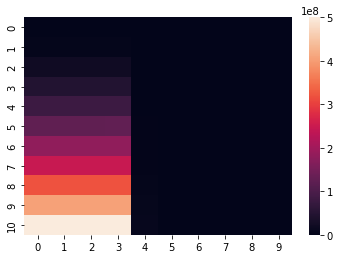

In [75]:
sns.heatmap(res)

In [15]:
import torch
from torch import nn
from matplotlib import pyplot as plt

Make a simple linear regression to test the ensembling

In [101]:
class Linear(torch.nn.Module):
    def __init__(self, n_in: int, n_out: int) -> None:
        super().__init__()
        self.nn = torch.nn.Sequential(torch.nn.Linear(n_in,n_out))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)


In [102]:
model = Linear(1,1)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

x = torch.rand((10000,1)) 
y_wo_noise = 3 * x + 2 * torch.sin(50*x)/10 + 2
noise =  torch.normal(0,0.2,x.shape)
y_w_noise_homo = y_wo_noise + noise
y_w_noise_hetero = y_wo_noise + noise * x 

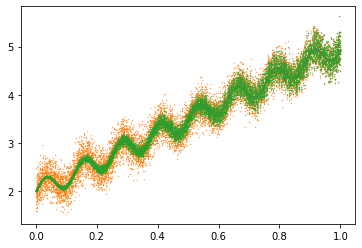

In [119]:
plt.scatter(x,y_wo_noise,s=0.1)
plt.scatter(x,y_w_noise_homo,s=0.1)
plt.scatter(x,y_w_noise_hetero,s=0.1)


In [84]:
y_wo_noise

tensor([[3.2891],
        [5.4268],
        [3.2603],
        [4.3073],
        [3.8436],
        [4.9832],
        [4.1258],
        [4.3340],
        [3.2474],
        [3.6754],
        [4.8264],
        [6.3798],
        [4.2115],
        [3.5512],
        [5.7193],
        [2.8053],
        [6.4361],
        [4.7540],
        [6.5411],
        [3.1098],
        [4.3576],
        [6.5244],
        [5.9699],
        [5.5337],
        [3.7842],
        [2.8735],
        [4.9354],
        [5.7105],
        [2.4138],
        [2.3923],
        [4.1464],
        [3.8757],
        [2.4575],
        [2.5472],
        [5.6848],
        [2.5511],
        [2.2573],
        [3.2673],
        [4.5978],
        [6.0049],
        [4.6573],
        [6.0028],
        [5.7105],
        [2.8612],
        [5.9325],
        [4.0648],
        [3.0044],
        [5.6614],
        [3.2085],
        [2.3151],
        [5.5471],
        [5.0202],
        [2.2270],
        [5.3551],
        [6.5276],
        [5

In [105]:
model = Linear(1,1)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

x = torch.rand((1000,1)) 
y_wo_noise = 3 * x + 2
noise =  torch.normal(0,0.2,x.shape)
y_w_noise_homo = y_wo_noise + noise
y_w_noise_hetero = y_wo_noise + noise * x

for e in range(1000):
    pred = model(x)
    print(x.requires_grad)
    l = loss(pred,y_w_noise_hetero)
    print(l.requires_grad)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True
False
True

In [52]:
**(10,10,10)

SyntaxError: invalid syntax (1178904007.py, line 1)

In [71]:
model.nn[0]._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[2.9820]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([2.0035], requires_grad=True))])

In [122]:
torch.__version__

'1.12.1'

In [123]:
! pip install pytorch

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/7y/yhl65v0j5m3g8zj_xwkzq44w0000gn/T/pip-install-10sih1ov/pytorch_bb24d1c8652a4929a8aab5bb09152d4e/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  Running setup.py install for pytorch ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exi

In [126]:
!pip3 install torch==1.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 4.4 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.12.1


In [128]:
import torch.masked
import torch.sparse

In [190]:
X

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [189]:
eye_mask

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [False,  True, False, False, False, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False, False, False],
        [False, False, False, False,  True, False, False, False, False, False],
        [False, False, False, False, False,  True, False, False, False, False],
        [False, False, False, False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False,  True, False, False],
        [False, False, False, False, False, False, False, False,  True, False],
        [False, False, False, False, False, False, False, False, False,  True]])

In [2]:
from torch.masked import masked_tensor
import torch

In [3]:
X = torch.arange(100,dtype=float).reshape(10,10)
eye_mask = torch.eye(10,dtype=bool)

In [4]:
X.shape

torch.Size([10, 10])

In [5]:
eye_mask.shape

torch.Size([10, 10])

In [8]:
data = torch.arange(12, dtype=torch.float).reshape(3, 4)
mask = torch.tensor([[True, False, False, True], [False, True, False, False], [True, True, True, True]])
#data.requires_grad_ = False
mt = masked_tensor(data, mask)
data.select(0, 1)
mask.select(0, 1)
mt.select(0, 1)

MaskedTensor(
  [      --,   5.0000,       --,       --]
)

In [12]:
torch.sum(eye_mask,dim=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
X_masked = masked_tensor(X,eye_mask)

In [11]:
torch.mean(X_masked,dim=1)

/opt/anaconda3/envs/science/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


MaskedTensor(
  [  0.0000,  11.0000,  22.0000,  33.0000,  44.0000,  55.0000,  66.0000,  77.0000,  88.0000,  99.0000]
)

In [ ]:
# we define a
 

In [166]:
eye_tens = torch.eye(100) + torch.rot90(torch.eye(100).T)
sparse_eye = eye_tens.to_sparse()

In [9]:
torch.mean(eye_tens,dim=1)

NameError: name 'eye_tens' is not defined

In [ ]:
torch.mean(eye)

In [199]:
eye_tens

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.]])

In [200]:
torch.rot90(eye_tens)

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.]])

In [201]:
eye_tens

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [0., 0., 1.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.]])

In [155]:
class SimpleNN(torch.nn.Module):
    def __init__(self, n_in: int, n_hidden: int, n_out: int) -> None:
        super().__init__()
        self.nn = torch.nn.Sequential(nn.Linear(n_in,n_hidden),
                                      nn.Tanh(),
                                      nn.Linear(n_hidden,n_hidden),
                                      nn.Tanh(),
                                      nn.Linear(n_hidden,n_out)
            )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)

In [156]:
import cProfile

In [157]:
model_nn = SimpleNN(100,10,1)
#opt_model = torch.compile(model_nn)

In [158]:
model_nn()

TypeError: SimpleNN.forward() missing 1 required positional argument: 'x'

In [173]:
cProfile.run("for _ in range(100000): model_nn(sparse_eye) ")

         3600003 function calls (3000003 primitive calls) in 3.424 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.045    0.000    3.000    0.000 2107979986.py:11(forward)
        1    0.366    0.366    3.424    3.424 <string>:1(<module>)
   200000    0.026    0.000    0.681    0.000 activation.py:353(forward)
   100000    0.024    0.000    0.033    0.000 container.py:129(__iter__)
   100000    0.154    0.000    2.860    0.000 container.py:137(forward)
   300000    0.173    0.000    1.732    0.000 linear.py:113(forward)
700000/100000    0.293    0.000    3.057    0.000 module.py:1124(_call_impl)
   700000    0.124    0.000    0.124    0.000 module.py:1194(__getattr__)
        1    0.000    0.000    3.424    3.424 {built-in method builtins.exec}
   100000    0.005    0.000    0.005    0.000 {built-in method builtins.iter}
   700000    0.081    0.000    0.081    0.000 {built-in method torch._C._get_tracing_stat

In [180]:
cProfile.run("for _ in range(100000): model_nn(eye_tens)")

         3600003 function calls (3000003 primitive calls) in 4.155 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100000    0.060    0.000    3.681    0.000 2107979986.py:11(forward)
        1    0.410    0.410    4.155    4.155 <string>:1(<module>)
   200000    0.031    0.000    0.838    0.000 activation.py:353(forward)
   100000    0.028    0.000    0.037    0.000 container.py:129(__iter__)
   100000    0.210    0.000    3.510    0.000 container.py:137(forward)
   300000    0.249    0.000    2.083    0.000 linear.py:113(forward)
700000/100000    0.374    0.000    3.745    0.000 module.py:1124(_call_impl)
   700000    0.171    0.000    0.171    0.000 module.py:1194(__getattr__)
        1    0.000    0.000    4.155    4.155 {built-in method builtins.exec}
   100000    0.005    0.000    0.005    0.000 {built-in method builtins.iter}
   700000    0.098    0.000    0.098    0.000 {built-in method torch._C._get_tracing_stat

In [ ]:
# ------ TASK 1 ---------
# 1st write a simple torch energie SOAP BPNN
# 2nd get SOAP descriptors of a batch of 32/64/128 organic crystals
# 3rd get the values as torch.tensors get SOAPS both as dense and sparse arrays
# 4th compute and profile both sparse computations
# 5th also try gradients
# 6th eventually -> try different sparse formats

# ------- TASK 2 --------
# 1st 

In [ ]:
class Aggregator():
    # Abstract class that should implement things like checks etc.
    # an aggregator returns always   N_predictions_out ≤ N_predictions_in

    # aggregations should be both static and learnable
    # i.e. Structure_aggregate = mean([e_1,...e_N])
    # or   Structure_aggregate = mean([w_1*e_1, ...., w_N*e_N])
    # this learnable aggregation must be done along labeling invariant groups (i.e. Geometrical, or Species wise )
    pass

class AtomWiseAggregator():
    # empty class that does not aggregate and passes 
    pass

class GroupWiseAggregator():
    # uses masks to aggregate properties along user specific groups
    pass

class StructureWiseAggregator():
    # uses masks to aggregate properties along structures
    pass

class MirrorAggregator():
    # WHat if for some reason had to be done as a copy of images 
    # like in ring-polymer MD ?
    pass

class EnergyTask(StructureWiseAggregator):
    pass
